In [3]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from lib.dataloader import OCTSegDataset
import torch
import numpy as np
# Use your dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.2269175].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1247923..6.293835].


val dataset size: 82 images
Image shape: (512, 512, 3)
Target shape: torch.Size([512, 512])
Unique classes in target: tensor([0, 1, 2, 3])
Image min/max: -0.4823962 3.2269175


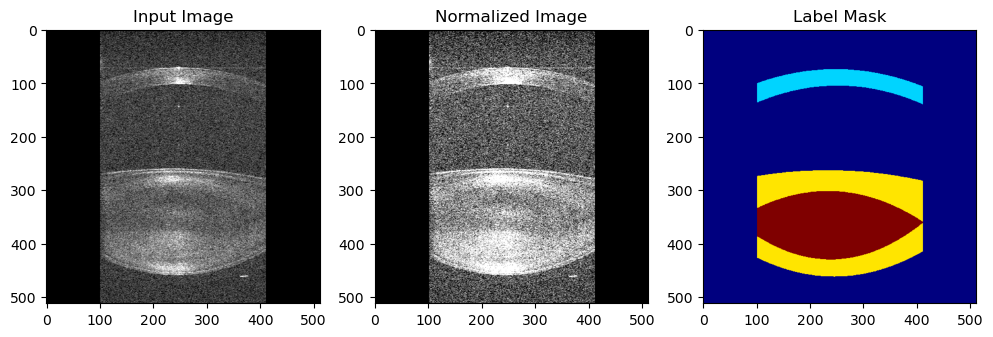

In [4]:
data_root = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/eye_data"

batch_size = 4
num_classes = 4
crop_size = 512

    # Train dataset
train_dataset = OCTSegDataset(root_dir=data_root, split="train", crop_size=(crop_size, crop_size))
val_dataset = OCTSegDataset(root_dir=data_root, split="val", crop_size=(crop_size, crop_size))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
print(f'val dataset size: {len(val_dataset)} images')
# Pick a sample
image, target = val_loader.dataset[0]  # first image and mask
image = image.permute(1, 2, 0).numpy()  # CHW to HWC
target2 = target.numpy()  # HxW

print("Image shape:", image.shape)
print("Target shape:", target.shape)
print("Unique classes in target:", torch.unique(target))

print("Image min/max:", image.min(), image.max())
# Convert target IDs to colors for visualization
image_norm = (image - 0.08) / 0.5


# p2, p98 = np.percentile(image, (2, 98))
# image_norm = np.clip((image_norm - p2) / (p98 - p2), 0, 1)

# image_norm = (image - image.min()) / (image.max() - image.min())

# Plot
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(image)  # image is PIL, already RGB

plt.subplot(1,3,2)
plt.title("Normalized Image")
plt.imshow(image_norm)

plt.subplot(1,3,3)
plt.title("Label Mask")
plt.imshow(target, cmap='jet', vmin=0, vmax=num_classes-1)  # target is 2D array of class IDs
plt.show()


Tensor shape: torch.Size([1, 3, 512, 512])


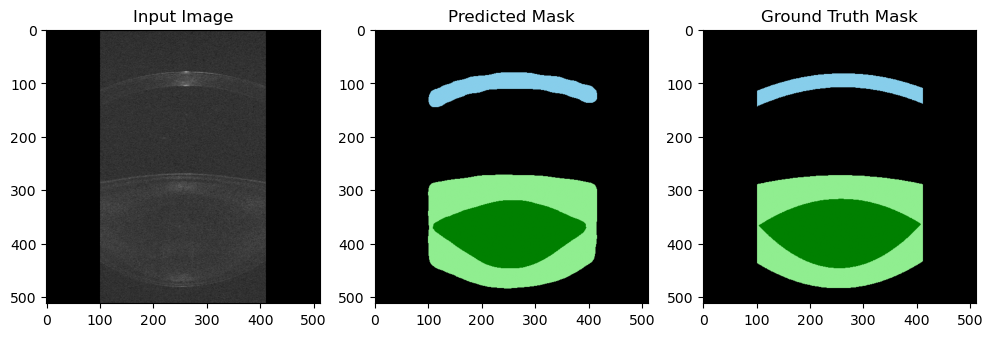

In [207]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from matplotlib.colors import ListedColormap
from lib.models.model_zoo.t_net import tnet
from lib.models.model_zoo.ResNet50UNet import ResNet50UNet
from lib.models.UOCNet import UOCNet
from lib.models.UNET_OCT import UNET_OCT
import cv2 as cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_path = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/eye_data/images/val/CN035_JP_19_M_OD_6-0D_4_Horizontal.png"  # replace with your image path
image = Image.open(img_path).convert("RGB")  # grayscale

label_path = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/eye_data/labels/val/CN035_JP_19_M_OD_6-0D_4_Horizontal.png"  # replace with your image path
label = Image.open(label_path).convert("L")  

crop_size = 512

transform = transforms.Compose([
    transforms.Resize((crop_size, crop_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    transforms.Normalize(mean=[0.08,0.08,0.08], std=[0.5,0.5,0.5])
])

img_tensor = transform(image).unsqueeze(0).to(device) 
print("Tensor shape:", img_tensor.shape)

def initialize_model(num_classes, device):
    try:
        # Load pretrained DeepLabV3
        model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
        model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1))
        # model = model.to(device)
       
        return model
    except Exception as e:
        
        raise
# -----------------------------
num_classes = 4
# model = models.segmentation.deeplabv3_resnet50(pretrained=True)
# model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1))
model = initialize_model(num_classes, device)
# model = UNET_OCT (num_classes=4, name = 'UNET_OCT_AIM').to(device)



# Load checkpoint
checkpoint_path = "runs/DeepLabV3_ResNet50_20251006_140615/checkpoints/DeepLabV3_ResNet50_epoch_20.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["state_dict"])
    
model.to(device)
model.eval()

# -----------------------------
# 4. Forward pass & prediction
# -----------------------------
with torch.no_grad():
    out_dict = model(img_tensor)
    output = out_dict['out'] if isinstance(out_dict, dict) else out_dict
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H,W]


colors = ['black', 'skyblue', 'lightgreen', 'green']
cmap = ListedColormap(colors)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(image)  

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1) 


plt.subplot(1,3,3)
plt.title("Ground Truth Mask")
plt.imshow(label, cmap=cmap, vmin=0, vmax=num_classes-1) 
# plt.imshow(diff, cmap='gray')

plt.show()


In [183]:
def get_contours(processed_img, threshold):
    (contours, hierarchies) = cv2.findContours(processed_img,
            cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return [cnt for cnt in contours if cv2.contourArea(cnt) > threshold]

In [184]:
def curvature_quadratic(poly_coeff, x):
    """
    Computes the curvature of the quadratic function f(x) = ax^2 + bx + c at a given x.
    κ(x) = ∣2a∣ / (1+(2ax+b)^2)^(3/2)​

    Args:
        poly_coeff[0] (float): Coefficient of x^2
        poly_coeff[1] (float): Coefficient of x
        poly_coeff[2] (float): Constant term
        x (np.array): The x-value(s) at which to compute curvature
    
    Returns:
        float or np.array: The curvature at the given x
    """
    f_prime = 2 * poly_coeff[0] * x + poly_coeff[1]
    f_double_prime = 2 * poly_coeff[0]
    
    # Compute curvature
    curvature = np.abs(f_double_prime) / (1 + f_prime**2) ** (3 / 2)
    
    return curvature

In [185]:
def curvature_cubic(poly_coeff, x):
    """
    Computes the curvature of the cubic function f(x) = ax^3 + bx^2 + cx + d at a given x.
    
    Args:
        poly_coeff[0] (float): Coefficient of x^3
        poly_coeff[1] (float): Coefficient of x^2
        poly_coeff[2] (float): Coefficient of x
        poly_coeff[3] (float): Constant term
        x (np.array): The x-value(s) at which to compute curvature
    
    Returns:
        np.array: The curvature at the given x
    """

    f_prime = 3 * poly_coeff[0] * x**2 + 2 * poly_coeff[1] * x + poly_coeff[2]
    f_double_prime = 6 * poly_coeff[0] * x + 2 * poly_coeff[1]
    
    curvature = np.abs(f_double_prime) / (1 + f_prime**2) ** (3 / 2)
    
    return curvature

In [186]:
def fit_circle(x, y):
    # Algebraic circle fit: (x - xc)^2 + (y - yc)^2 = r^2
    A = np.c_[2*x, 2*y, np.ones_like(x)]
    b = x**2 + y**2
    
    c, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    xc, yc = c[0], c[1]
    r = np.sqrt(c[2] + xc**2 + yc**2)
    return xc, yc, r

In [187]:
import cv2
import numpy as np

def undo_resize_with_padding(pred_img, original_size=(1400, 850), target_size=(512, 512)):
    """
    Convert a prediction image back to original image size.
    
    Parameters:
    - pred_img: np.array, the prediction (e.g., mask) of size target_size
    - original_size: tuple (H, W) of the original image
    - target_size: tuple (H, W) used for padding-resize
    
    Returns:
    - img_resized: np.array, resized back to original_size
    """
    th, tw = target_size
    oh, ow = original_size

    # Compute scale
    scale = min(tw / ow, th / oh)
    new_w, new_h = int(ow * scale), int(oh * scale)

    # Compute padding used during initial resize
    pad_w = (tw - new_w) // 2
    pad_h = (th - new_h) // 2

    # Remove padding
    cropped = pred_img[pad_h:pad_h+new_h, pad_w:pad_w+new_w]

    # Resize back to original size
    img_resized = cv2.resize(cropped, (ow, oh), interpolation=cv2.INTER_NEAREST)

    return img_resized


In [188]:
import numpy as np
import torch
from scipy.ndimage import binary_fill_holes
from skimage import morphology, measure

def clean_segmentation(mask, min_size=500, opening_radius=2, closing_radius=5, keep_largest=True):
    """
    mask: 2D numpy array with integer labels (H,W)
    returns: cleaned mask (H,W)
    """
    cleaned = np.zeros_like(mask)
    labels = np.unique(mask)
    labels = labels[labels != 0]  # skip background if label 0

    for lbl in labels:
        region = (mask == lbl)

        # 1. remove small objects
        region = morphology.remove_small_objects(region, min_size=min_size)

        # 2. fill holes
        region = binary_fill_holes(region)

        # 3. morphological open/close
        selem_open = morphology.disk(opening_radius)
        selem_close = morphology.disk(closing_radius)
        region = morphology.binary_opening(region, selem_open)
        region = morphology.binary_closing(region, selem_close)

        # 4. keep largest component
        if keep_largest:
            labeled = measure.label(region)
            if labeled.max() > 0:
                largest = max(measure.regionprops(labeled), key=lambda x: x.area).label
                region = (labeled == largest)
            else:
                region = np.zeros_like(region)

        cleaned[region] = lbl

    return cleaned


## Identiry anterior and posterior surfaces
1. From the predicted segmentation mask, only takes Cornea Mask for further processing
2. Find outer and inner surface of the Cornea

 x: 850, anterior: 850, posterior: 850


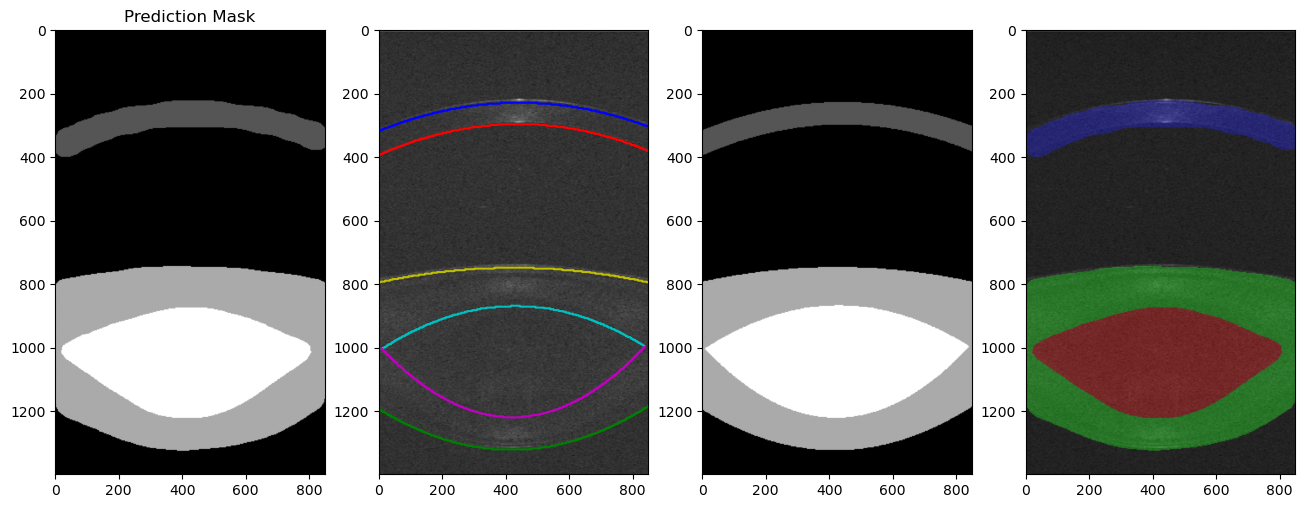

In [208]:
image2 = undo_resize_with_padding(np.array(image), original_size=(1400, 850), target_size=(crop_size, crop_size))
pred2 = undo_resize_with_padding(pred, original_size=(1400, 850), target_size=(crop_size, crop_size))
label2 = undo_resize_with_padding(np.array(label), original_size=(1400, 850), target_size=(crop_size, crop_size))

x_pix = 7.1  # microns
y_pix = 9.819  # microns


# Convert to physical coordinates

# image2 = image2[:, 215:635]
# pred2 = pred2[:, 215:635]
# label2 = label2[:, 215:635]
# print(f"image shape: {image2.shape}, pred shape: {pred2.shape}, label shape: {label2.shape}")


# cornea_mask = (pred2 == 1 ).astype(np.uint8)                   # [H, W]
# lens_mask = (pred2 == 2 ).astype(np.uint8) 
# nucleus_mask = (pred2 == 3 ).astype(np.uint8) 

cornea_mask = (label2 == 1 ).astype(np.uint8)                   # [H, W]
lens_mask = (label2 == 2 ).astype(np.uint8) 
nucleus_mask = (label2 == 3 ).astype(np.uint8) 

def extract_surface(mask):
    H, W = mask.shape
    anterior = np.zeros(W, dtype=float)
    posterior = np.zeros(W, dtype=float)

    for col in range(W):
        ys = np.where(mask[:, col] > 0)[0] 
        # print(f"Column {col}: ys = {len(ys)}")
        if len(ys) > 0:
            anterior[col] = ys[1]        
            posterior[col] = ys[-3]      
        else:
            anterior[col] = np.nan       
            posterior[col] = np.nan

    x1 = np.arange(W)
    y1 = anterior
    y2 = posterior
    return x1, y1, y2

x1, y1, y2 = extract_surface(cornea_mask)
x2, y1_nucleus, y2_nucleus = extract_surface(nucleus_mask)
x3, y1_lens, y2_lens = extract_surface(lens_mask)

img = image2.copy()
color_map = {
    0: (0, 0, 0),       # black  - background
    1: (0, 0, 255),     # blue   - segment 1
    2: (0, 255, 0),     # green  - segment 2
    3: (255, 0, 0)      # red    - segment 3
}
colorpred = np.zeros((pred2.shape[0], pred2.shape[1], 3), dtype=np.uint8)
for k, color in color_map.items():
    colorpred[pred2 == k] = color

overlay = cv2.addWeighted(img, 0.7, colorpred, 0.3, 0)
# overlay = cv2.addWeighted(colorpred, 0.2, img, 0.8,0)

print(f' x: {len(x1)}, anterior: {len(y1)}, posterior: {len(y2)}')

plt.figure(figsize=(16,6))
plt.subplot(1,4,1)
plt.imshow(pred2, cmap='gray')
# plt.plot(range(len(x1)), y1, 'b-', label='Anterior')
# plt.plot(range(len(x1)), y2, 'r-', label='Posterior')
# plt.plot(range(len(x1)), y1_nucleus, 'c-', label='Nucleus')
# plt.plot(range(len(x1)), y2_nucleus, 'm-', label='Nucleus')
# plt.plot(range(len(x1)), y1_lens, 'y-', label='Lens')
# plt.plot(range(len(x1)), y2_lens, 'g-', label='Lens')
# plt.imshow(lens_mask, cmap='gray')
# plt.imshow(nucleus_mask, cmap='gray')
plt.title("Prediction Mask")
# plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(image2, cmap='gray')
plt.plot(range(len(x1)), y1, 'b-', label='Anterior')
plt.plot(range(len(x1)), y2, 'r-', label='Posterior')
plt.plot(range(len(x1)), y1_nucleus, 'c-', label='Nucleus')
plt.plot(range(len(x1)), y2_nucleus, 'm-', label='Nucleus')
plt.plot(range(len(x1)), y1_lens, 'y-', label='Lens')
plt.plot(range(len(x1)), y2_lens, 'g-', label='Lens')
# plt.legend()
# plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(label2, cmap='gray')

plt.subplot(1,4,4)
plt.imshow(overlay, cmap='gray')

plt.show()

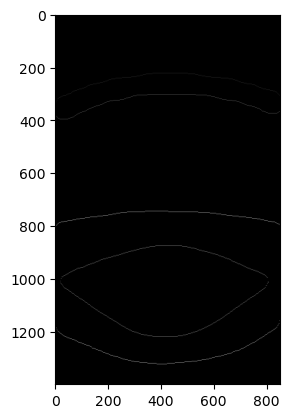

In [166]:
mask_d = np.zeros_like(pred2, dtype=np.uint8)

def draw_curve(mask, y_curve, value=1):
    for x, y in enumerate(y_curve):
        if not np.isnan(y):
            y_int = int(round(y))
            if 0 <= y_int < mask.shape[0]:
                mask[y_int, x] = value
    return mask

# Draw label curves
mask_d = draw_curve(mask_d, y1, value=1)          # Cornea anterior
mask_d = draw_curve(mask_d, y2, value=2)          # Cornea posterior
mask_d = draw_curve(mask_d, y1_nucleus, value=3)  # Nucleus anterior
mask_d = draw_curve(mask_d, y2_nucleus, value=3)  # Nucleus posterior
mask_d = draw_curve(mask_d, y1_lens, value=4)     # Lens anterior
mask_d = draw_curve(mask_d, y2_lens, value=4)     # Lens posterior

# Optional: visualize
plt.imshow(mask_d, cmap='gray')
plt.show()

# Save as .bin (raw binary)
mask_d.tofile("pred_mask.bin")

In [210]:
cornea_mask = (label2 == 1 ).astype(np.uint8)                   # [H, W]
lens_mask = (label2 == 2 ).astype(np.uint8) 
nucleus_mask = (label2 == 3 ).astype(np.uint8) 

cornea_mask1 = (pred2 == 1 ).astype(np.uint8)                   # [H, W]
lens_mask1 = (pred2 == 2 ).astype(np.uint8) 
nucleus_mask1 = (pred2 == 3 ).astype(np.uint8) 

def extract_surface(mask):
    H, W = mask.shape
    anterior = np.zeros(W, dtype=float)
    posterior = np.zeros(W, dtype=float)

    for col in range(W):
        ys = np.where(mask[:, col] > 0)[0] 
        # print(f"Column {col}: ys = {len(ys)}")
        if len(ys) > 0:
            anterior[col] = ys[0]        
            posterior[col] = ys[-3]      
        else:
            anterior[col] = np.nan       
            posterior[col] = np.nan

    x1 = np.arange(W)
    y1 = anterior
    y2 = posterior
    return x1, y1, y2

# --- label-------
x1, y1, y2 = extract_surface(cornea_mask)
x2, y1_nucleus, y2_nucleus = extract_surface(nucleus_mask)
x3, y1_lens, y2_lens = extract_surface(lens_mask)
# --- pred-------
x1p, y1p, y2p = extract_surface(cornea_mask1)
x2p, y1_nucleusp, y2_nucleusp = extract_surface(nucleus_mask1)
x3p, y1_lensp, y2_lensp = extract_surface(lens_mask1)


def compute_curve_difference(y_label, y_pred):
    """
    Computes the point-wise difference between label and prediction curves.
    Returns an array of differences and ignores NaN values.
    """
    diff = np.full_like(y_label, np.nan, dtype=float)
    mask = ~np.isnan(y_label) & ~np.isnan(y_pred)
    diff[mask] = y_pred[mask] - y_label[mask]
    return diff

# --- Cornea ---
cornea_anterior_diff = compute_curve_difference(y1, y1p)
cornea_posterior_diff = compute_curve_difference(y2, y2p)

# --- Lens ---
lens_anterior_diff = compute_curve_difference(y1_lens, y1_lensp)
lens_posterior_diff = compute_curve_difference(y2_lens, y2_lensp)

# --- Nucleus ---
nucleus_anterior_diff = compute_curve_difference(y1_nucleus, y1_nucleusp)
nucleus_posterior_diff = compute_curve_difference(y2_nucleus, y2_nucleusp)

print("Cornea anterior mean difference:", np.nanmean(cornea_anterior_diff))
print("Cornea posterior mean difference:", np.nanmean(cornea_posterior_diff))
print("Lens anterior mean difference:", np.nanmean(lens_anterior_diff))
print("Lens posterior mean difference:", np.nanmean(lens_posterior_diff))
print("Nucleus anterior mean difference:", np.nanmean(nucleus_anterior_diff))
print("Nucleus posterior mean difference:", np.nanmean(nucleus_posterior_diff))


Cornea anterior mean difference: -2.172941176470588
Cornea posterior mean difference: 8.248235294117647
Lens anterior mean difference: -2.231764705882353
Lens posterior mean difference: -0.21411764705882352
Nucleus anterior mean difference: 11.841168996188056
Nucleus posterior mean difference: -6.5908513341804325


## Fit Polynomial Curve on the Anterior Surface of the Cornea

Fit values (a, b, c, d): [-2.06617168e-10  4.55185420e-04 -4.02824737e-01  3.15987363e+02]


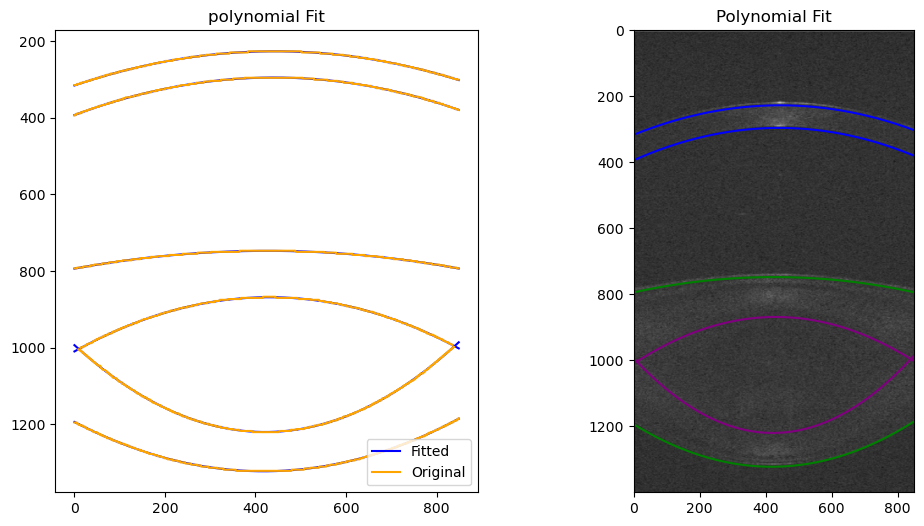

In [211]:
# Helper to filter out NaNs for polyfit
def safe_polyfit(x, y, deg):
	mask = ~np.isnan(x) & ~np.isnan(y)
	return np.polyfit(x[mask], y[mask], deg)

fit_values1 = safe_polyfit(x1, y1, 3)
print("Fit values (a, b, c, d):", fit_values1)
model1 = np.poly1d(fit_values1)
y1_fit = model1(x1)

fit_values2 = safe_polyfit(x1, y2, 3)
model3 = np.poly1d(fit_values2)
y2_fit = model3(x1)

fit_values3 = safe_polyfit(x2, y1_lens, 3)
model4 = np.poly1d(fit_values3)
y1_lens_fit = model4(x2)

fit_values4 = safe_polyfit(x2, y2_lens, 3)
model5 = np.poly1d(fit_values4)
y2_lens_fit = model5(x2)

fit_values5 = safe_polyfit(x3, y1_nucleus, 3)
model6 = np.poly1d(fit_values5)
y1_nucleus_fit = model6(x3)

fit_values6 = safe_polyfit(x3, y2_nucleus, 3)
model7 = np.poly1d(fit_values6)
y2_nucleus_fit = model7(x3)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x1, y1_fit, color='blue')
plt.plot(x1, y1, color='orange')
plt.plot(x1, y2_fit, color='blue')
plt.plot(x1, y2, color='orange')

plt.plot(x1, y1_lens_fit, color='blue')
plt.plot(x1, y1_lens, color='orange')
plt.plot(x1, y2_lens_fit, color='blue')
plt.plot(x1, y2_lens, color='orange')

plt.plot(x1, y1_nucleus_fit, color='blue')
plt.plot(x1, y1_nucleus, color='orange')
plt.plot(x1, y2_nucleus_fit, color='blue')
plt.plot(x1, y2_nucleus, color='orange')

plt.legend(['Fitted', 'Original'])
plt.title("polynomial Fit")
plt.gca().invert_yaxis()
# plt.axis("off")


plt.subplot(1,2,2)
plt.imshow(image2, cmap='gray')
# plt.plot(x1, y1, color='orange')
plt.plot(x1, y1_fit, color='blue')
plt.plot(x1, y2_fit, color='blue')

plt.plot(x2, y1_lens_fit, color='green')
plt.plot(x2, y2_lens_fit, color='green')

plt.plot(x2, y1_nucleus_fit, color='purple')
plt.plot(x2, y2_nucleus_fit, color='purple')
plt.title("Polynomial Fit")
# plt.axis("off")
plt.show()

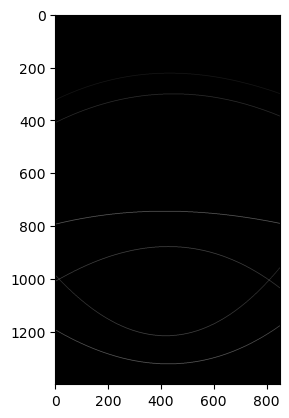

In [177]:
mask_d = np.zeros_like(pred2, dtype=np.uint8)

def draw_curve(mask, y_curve, value=1):
    for x, y in enumerate(y_curve):
        if not np.isnan(y):
            y_int = int(round(y))
            if 0 <= y_int < mask.shape[0]:
                mask[y_int, x] = value
    return mask

# Draw label curves
mask_d = draw_curve(mask_d, y1_fit, value=1)          # Cornea anterior
mask_d = draw_curve(mask_d, y2_fit, value=2)          # Cornea posterior
mask_d = draw_curve(mask_d, y1_nucleus_fit, value=3)  # Nucleus anterior
mask_d = draw_curve(mask_d, y2_nucleus_fit, value=3)  # Nucleus posterior
mask_d = draw_curve(mask_d, y1_lens_fit, value=4)     # Lens anterior
mask_d = draw_curve(mask_d, y2_lens_fit, value=4)     # Lens posterior

# Optional: visualize
plt.imshow(mask_d, cmap='gray')
plt.show()

# Save as .bin (raw binary)
mask_d.tofile("pred_mask_fit.bin")

## Pixels to Optical spacing

In [212]:
import numpy as np

def polyfit(x, y, deg):
    mask = ~np.isnan(x) & ~np.isnan(y)
    if np.sum(mask) < deg + 1:
        return np.full_like(y, np.nan, dtype=float)
    
    fit_value = np.polyfit(x[mask], y[mask], deg)
    model = np.poly1d(fit_value)
    y_fit = model(x[mask])

    y_full = np.full_like(y, np.nan, dtype=float)
    y_full[mask] = y_fit

    return y_full


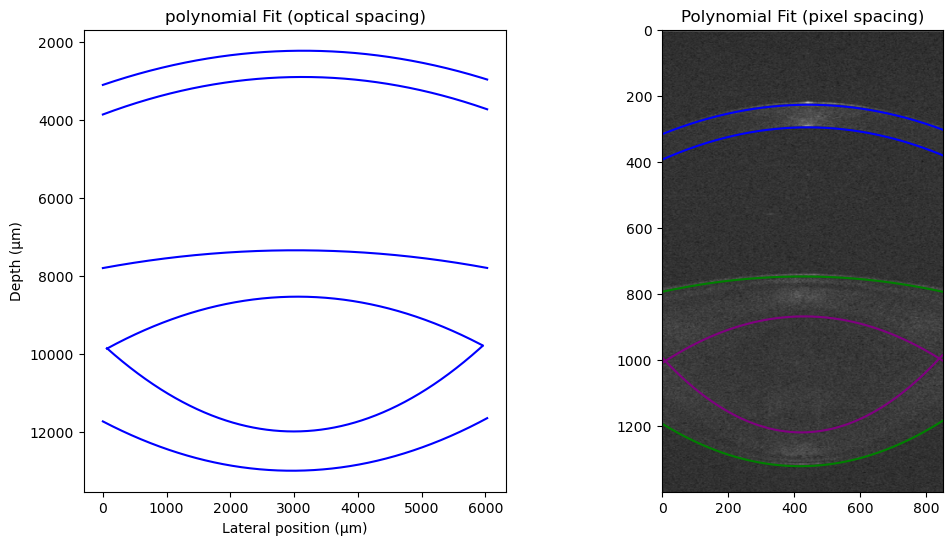

In [213]:
x_pix = 7.1  # microns
y_pix = 9.819  # microns

x1phy = x1 * x_pix
x2phy = x2 * x_pix
x3phy = x3 * x_pix
y1phy = y1 * y_pix
y2phy = y2 * y_pix
y1_lensphy = y1_lens * y_pix
y2_lensphy = y2_lens * y_pix
y1_nucleusphy = y1_nucleus * y_pix
y2_nucleusphy = y2_nucleus * y_pix


y1_fit_phy = polyfit(x1phy, y1phy, 3)
y2_fit_phy = polyfit(x1phy, y2phy, 3)
y1_lens_fit_phy = polyfit(x2phy, y1_lensphy, 3)
y2_lens_fit_phy = polyfit(x2phy, y2_lensphy, 3)
y1_nucleus_fit_phy = polyfit(x3phy, y1_nucleusphy, 3)
y2_nucleus_fit_phy = polyfit(x3phy, y2_nucleusphy, 3)


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x1phy, y1_fit_phy, color='blue')
# plt.plot(x1phy, -y1phy, color='orange')

plt.plot(x1phy, y2_fit_phy, color='blue')
# plt.plot(x1phy, -y2phy, color='orange')

plt.plot(x1phy, y1_lens_fit_phy, color='blue')
# plt.plot(x1phy, -y1_lensphy, color='orange')

plt.plot(x1phy, y2_lens_fit_phy, color='blue')
# plt.plot(x1phy, -y2_lensphy, color='orange')

plt.plot(x1phy, y1_nucleus_fit_phy, color='blue')
# plt.plot(x1phy, -y1_nucleusphy, color='orange')

plt.plot(x1phy, y2_nucleus_fit_phy, color='blue')
# plt.plot(x1phy, -y2_nucleusphy, color='orange')

# plt.legend(['Fitted', 'Original'])
plt.title("polynomial Fit (optical spacing)")
plt.ylabel('Depth (µm)')
plt.xlabel('Lateral position (µm)') # µm
# plt.axis("off")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.imshow(image2, cmap='gray')
# plt.plot(x1, y1, color='orange')
plt.plot(x1, y1_fit, color='blue')
plt.plot(x1, y2_fit, color='blue')

plt.plot(x2, y1_lens_fit, color='green')
plt.plot(x2, y2_lens_fit, color='green')

plt.plot(x2, y1_nucleus_fit, color='purple')
plt.plot(x2, y2_nucleus_fit, color='purple')
plt.title("Polynomial Fit (pixel spacing)")

# plt.axis("off")
plt.show()

Summary of runs (all radii in mm):

AXIAL CORRECTION: none, n_ax = None
  Local apex RoC (from poly): 5.643 mm
  Global circle fit: R = 5.989 mm (cost=3.51e+04)

AXIAL CORRECTION: divide_by_cornea_n, n_ax = 1.376
  Local apex RoC (from poly): 7.764 mm
  Global circle fit: R = 8.017 mm (cost=1.58e+04)

AXIAL CORRECTION: divide_by_aqueous_n, n_ax = 1.336
  Local apex RoC (from poly): 7.539 mm
  Global circle fit: R = 7.799 mm (cost=1.69e+04)



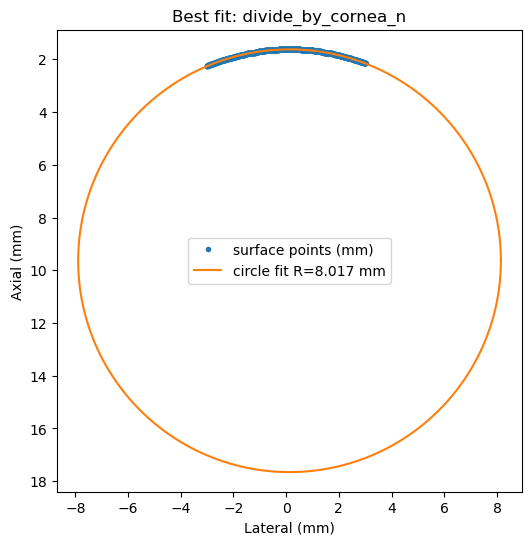

In [231]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# ---------- USER SETTINGS ----------
use_pixels = False  # already in µm
lateral_res = 7.1      # µm per pixel (x)
axial_res = 9.819      # µm per pixel (y)

n_air = 1.0003
n_cornea = 1.376
n_aqueous = 1.336

# ---------- Ensure you have ----------
# x1phy, y1_fit_phy

# ----------------- helper functions -----------------
def convert_to_geometric(x_vals, y_vals, lateral_res, axial_res, n_axial=None):
    x_um = x_vals * lateral_res if use_pixels else x_vals
    y_um = y_vals * axial_res if use_pixels else y_vals
    if n_axial is not None:
        y_um = y_um / n_axial
    return x_um, y_um

def circle_fit_leastsq(x, y):
    x = x.astype(float)
    y = y.astype(float)
    x0, y0 = np.mean(x), np.mean(y)
    R0 = np.mean(np.sqrt((x - x0)**2 + (y - y0)**2))
    def residuals(c):
        xc, yc, R = c
        return np.sqrt((x - xc)**2 + (y - yc)**2) - R
    res = least_squares(residuals, x0=[x0, y0, R0], xtol=1e-12, ftol=1e-12)
    xc, yc, R = res.x
    return xc, yc, abs(R), res.cost

def analytic_R_from_poly(poly, x_eval):
    dp = poly.deriv(1)(x_eval)
    ddp = poly.deriv(2)(x_eval)
    eps = 1e-12
    ddp = np.where(np.abs(ddp) < eps, eps, ddp)
    R = ((1.0 + dp**2)**1.5) / np.abs(ddp)
    return R

# ----------------- main loop -----------------
axial_options = {
    "none": None,
    "divide_by_cornea_n": n_cornea,
    "divide_by_aqueous_n": n_aqueous
}

results = []

for label, n_ax in axial_options.items():
    x_um, y_um = convert_to_geometric(x1phy, y1phy, lateral_res, axial_res, n_ax)
    x_centered = x_um - np.mean(x_um)
    mask = ~np.isnan(y_um)

    # Polynomial fit (for apex curvature)
    coeffs = np.polyfit(x_centered[mask], y_um[mask], 3)
    poly = np.poly1d(coeffs)
    xs_dense = np.linspace(x_centered.min(), x_centered.max(), 2000)
    R_vals = analytic_R_from_poly(poly, xs_dense)
    apex_idx = np.argmin(poly(xs_dense))
    R_apex_local = R_vals[apex_idx]

    # Circle fit using ALL points
    xc, yc, R_circle, cost = circle_fit_leastsq(x_centered[mask], y_um[mask])

    results.append({
        "label": label,
        "n_axial": n_ax,
        "poly": poly,
        "x_centered": x_centered,
        "y_um": y_um,
        "R_apex_local_um": R_apex_local,
        "circle": (xc, yc, R_circle, cost)
    })

# ----------------- summary -----------------
print("Summary of runs (all radii in mm):\n")
for r in results:
    xc, yc, R_circle, cost = r["circle"]
    print(f"AXIAL CORRECTION: {r['label']}, n_ax = {r['n_axial']}")
    print(f"  Local apex RoC (from poly): {r['R_apex_local_um']/1000:.3f} mm")
    print(f"  Global circle fit: R = {R_circle/1000:.3f} mm (cost={cost:.2e})\n")

# ----------------- Plot best run -----------------
best_run = max(results, key=lambda r: r["circle"][2])  # largest radius
xc, yc, R_circle, _ = best_run["circle"]
x_c = best_run["x_centered"]
y_c = best_run["y_um"]

theta = np.linspace(0, 2*np.pi, 400)
xc_pts = xc + R_circle * np.cos(theta)
yc_pts = yc + R_circle * np.sin(theta)

plt.figure(figsize=(6,6))
plt.plot(x_c/1000, y_c/1000, '.', label='surface points (mm)')
plt.plot(xc_pts/1000, yc_pts/1000, '-', label=f'circle fit R={R_circle/1000:.3f} mm')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.legend()
plt.title(f"Best fit: {best_run['label']}")
plt.xlabel("Lateral (mm)")
plt.ylabel("Axial (mm)")
plt.show()


Summary of runs (all radii in mm):

AXIAL CORRECTION: none, n_ax = None
  Local apex RoC (from poly): 5.643 mm
  Circle fit ±1.5 mm: R = 5.732 mm (cost=2.11e+01)
  Circle fit ±3.0 mm: R = 5.987 mm (cost=7.77e+03)

AXIAL CORRECTION: divide_by_cornea_n, n_ax = 1.3765
  Local apex RoC (from poly): 7.767 mm
  Circle fit ±1.5 mm: R = 7.832 mm (cost=3.13e+00)
  Circle fit ±3.0 mm: R = 8.018 mm (cost=1.20e+03)

AXIAL CORRECTION: divide_by_aqueous_n, n_ax = 1.3266
  Local apex RoC (from poly): 7.486 mm
  Circle fit ±1.5 mm: R = 7.553 mm (cost=3.90e+00)
  Circle fit ±3.0 mm: R = 7.746 mm (cost=1.50e+03)

Plotting best run: divide_by_cornea_n, circle R = 8.018 mm for ±3.0 mm


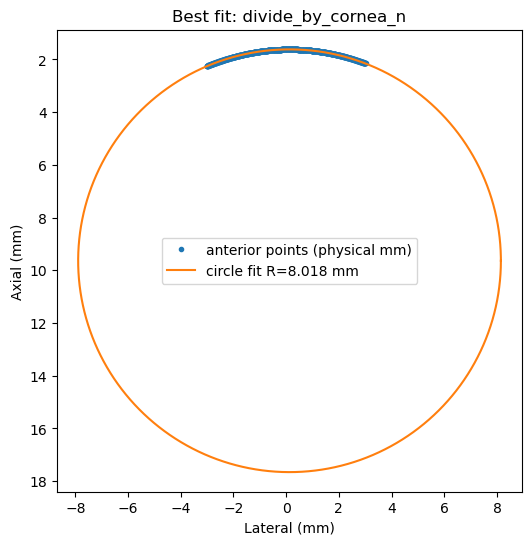

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# ---------- USER SETTINGS ----------
# If your x1phy/y1_fit_phy are already in µm, set use_pixels=False.
# If they are still pixel indices, set use_pixels=True and provide spacing.
use_pixels = False

# If using pixel indices:
lateral_res = 7.1      # µm per pixel (x)  — replace if different
axial_res = 9.819      # µm per pixel (y)  — replace if different

# Refractive indices to try for axial correction
# n_air = 1.0003
# n_cornea = 1.376
# n_aqueous = 1.336

n_air = 1.000
n_cornea = 1.3765
n_aqueous = 1.3266
n_lens = 1.349

# central zones to try (µm)
central_zones = [1500.0, 3000.0]  # ±1.5 mm, ±3.0 mm

# ---------- Ensure you have these variables from your notebook ----------
# x1phy, y1_fit_phy  (if use_pixels=True then these are pixel indices)
# If you used earlier variable names, they should be present.

# ----------------- helper functions -----------------
def convert_to_geometric(x_vals, y_vals, lateral_res, axial_res, n_axial=None):
    """
    Convert pixel indices -> physical µm. If n_axial provided, divide axial by n_axial.
    x_vals, y_vals may already be in µm; if use_pixels True handle accordingly.
    """
    x_um = x_vals * lateral_res if use_pixels else x_vals
    y_um = y_vals * axial_res if use_pixels else y_vals
    if n_axial is not None:
        y_um = y_um / n_axial
    return x_um, y_um

def circle_fit_leastsq(x, y):
    """
    Fit circle (xc, yc, R) by minimizing residuals sqrt((x-xc)^2+(y-yc)^2)-R.
    Returns (xc, yc, R).
    """
    x = x.astype(float)
    y = y.astype(float)
    # initial guess: center at mean, radius ~ mean distance to mean
    x0 = np.mean(x)
    y0 = np.mean(y)
    R0 = np.mean(np.sqrt((x - x0)**2 + (y - y0)**2))
    def residuals(c):
        xc, yc, R = c
        return np.sqrt((x - xc)**2 + (y - yc)**2) - R
    res = least_squares(residuals, x0=[x0, y0, R0], xtol=1e-12, ftol=1e-12)
    xc, yc, R = res.x
    return xc, yc, abs(R), res.cost

def analytic_R_from_poly(poly, x_eval):
    dp = poly.deriv(1)(x_eval)
    ddp = poly.deriv(2)(x_eval)
    eps = 1e-12
    ddp = np.where(np.abs(ddp) < eps, eps, ddp)
    R = ((1.0 + dp**2)**1.5) / np.abs(ddp)
    return R

# ----------------- diagnostics & runs -----------------
# Choose axial corrections to try: (None = no division), cornea, aqueous
axial_options = {
    "none": None,
    "divide_by_cornea_n": n_cornea,
    "divide_by_aqueous_n": n_aqueous
}

results = []

for label, n_ax in axial_options.items():
    # convert coordinates
    x_um, y_um = convert_to_geometric(x1phy if use_pixels else x1phy,
                                     y1_fit_phy if use_pixels else y1_fit_phy,
                                     lateral_res, axial_res, n_ax)
    # center x if not centered
    x_centered = x_um - np.mean(x_um)
    # create poly in physical coords (deg 3)
    mask = ~np.isnan(y_um)
    coeffs = np.polyfit(x_centered[mask], y_um[mask], 3)
    poly = np.poly1d(coeffs)
    # analytic RoC at apex:
    xs_dense = np.linspace(x_centered.min(), x_centered.max(), 2000)
    R_vals = analytic_R_from_poly(poly, xs_dense)
    apex_idx = np.argmin(poly(xs_dense))
    R_apex_local = R_vals[apex_idx]

    # try circle fits for different central zones
    zone_results = {}
    for zone in central_zones:
        mask_zone = (np.abs(x_centered) <= zone) & mask
        if mask_zone.sum() < 6:
            zone_results[zone] = (np.nan, np.nan, np.nan, "not_enough_points")
            continue
        xc, yc, R_circle, cost = circle_fit_leastsq(x_centered[mask_zone], y_um[mask_zone])
        # store circle result
        zone_results[zone] = (xc, yc, R_circle, cost)

    results.append({
        "label": label,
        "n_axial": n_ax,
        "poly": poly,
        "x_centered": x_centered,
        "y_um": y_um,
        "R_apex_local_um": R_apex_local,
        "zone_results": zone_results
    })

# ----------------- print summary -----------------
print("Summary of runs (all radii in mm):\n")
for r in results:
    print(f"AXIAL CORRECTION: {r['label']}, n_ax = {r['n_axial']}")
    print(f"  Local apex RoC (from poly): {r['R_apex_local_um']/1000:.3f} mm")
    for zone, val in r['zone_results'].items():
        if isinstance(val, tuple):
            xc, yc, R_circle, cost = val
            if np.isnan(R_circle):
                print(f"  Circle fit ±{zone/1000:.1f} mm: not enough points")
            else:
                print(f"  Circle fit ±{zone/1000:.1f} mm: R = {R_circle/1000:.3f} mm (cost={cost:.2e})")
    print("")

# ----------------- Plot the best candidate (choose the run you prefer) -----------------
# For convenience, pick the axial option that produced largest circle radius for ±3mm zone
best_run = None
best_R = -np.inf
for r in results:
    zone = central_zones[-1]  # ±3mm
    val = r["zone_results"].get(zone)
    if val and not isinstance(val[0], str):
        Rtmp = val[2]
        if not np.isnan(Rtmp) and Rtmp > best_R:
            best_R = Rtmp
            best_run = r

if best_run is not None:
    print(f"Plotting best run: {best_run['label']}, circle R = {best_R/1000:.3f} mm for ±{central_zones[-1]/1000:.1f} mm")
    x_c = best_run["x_centered"]
    y_c = best_run["y_um"]
    # get circle fit for ±zone
    xc, yc, R_circle, _ = best_run["zone_results"][central_zones[-1]]
    theta = np.linspace(0, 2*np.pi, 400)
    xc_pts = xc + R_circle * np.cos(theta)
    yc_pts = yc + R_circle * np.sin(theta)

    plt.figure(figsize=(6,6))
    plt.plot(x_c/1000, y_c/1000, '.', label='anterior points (physical mm)')
    plt.plot(xc_pts/1000, yc_pts/1000, '-', label=f'circle fit R={R_circle/1000:.3f} mm')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.legend()
    plt.title(f"Best fit: {best_run['label']}")
    plt.xlabel("Lateral (mm)")
    plt.ylabel("Axial (mm)")
    plt.show()

else:
    print("No valid run for plotting (not enough points).")


Corrected apex RoC (object-space), units = µm (divide by 1000 for mm):
Anterior cornea RoC (apex): 7.764 mm  (apex x = 3142.1 µm)
Posterior cornea RoC (apex): 8.665 mm (apex x = 3160.2 µm)
Lens anterior RoC (apex): 5.239 mm (apex x = 3190.4 µm)
Lens posterior RoC (apex): 2.127 mm (apex x = 3069.7 µm)


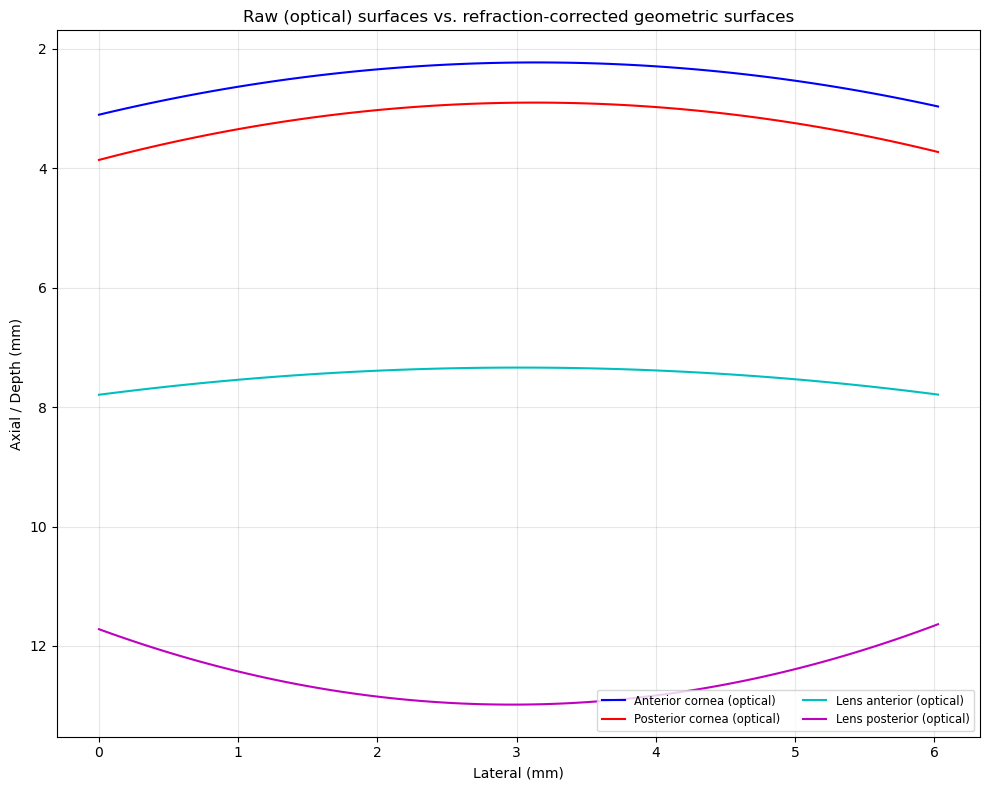

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# === USER / ENV parameters (adjust if needed) ===
# Refractive indices
n_air = 1.0003
n_cornea = 1.376
n_aqueous = 1.336
n_lens = 1.41

# number of rays / lateral samples
num_rays = 121

# units: assume your x*_phy and y*_fit_phy are in micrometers (µm) already
# If not, convert appropriately before running.

# === Helper functions ===
def fit_poly_safe(x, y, deg=3):
    mask = (~np.isnan(x)) & (~np.isnan(y))
    if mask.sum() < deg+1:
        raise RuntimeError("Not enough valid points for polyfit")
    coeffs = np.polyfit(x[mask], y[mask], deg)
    return np.poly1d(coeffs)

def compute_normals_from_poly(poly, x_pts, eps=1e-6):
    # returns unit normals (nx, ny) for surface y = poly(x)
    dy_dx = poly.deriv(1)(x_pts)
    normals = np.vstack([-dy_dx, np.ones_like(dy_dx)]).T
    norms = np.linalg.norm(normals, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    normals = normals / norms
    return normals

def refract_vec_2d(k_inc, normal, n1, n2):
    # vector form Snell (2D). k_inc and normal are 2-element arrays, normals outward to incident medium
    k = k_inc / np.linalg.norm(k_inc)
    n = normal / np.linalg.norm(normal)
    cos_i = -np.dot(n, k)
    cos_i = np.clip(cos_i, -1.0, 1.0)
    sin_t2 = (n1 / n2)**2 * (1 - cos_i**2)
    if sin_t2 > 1.0:
        return None
    cos_t = np.sqrt(max(0.0, 1 - sin_t2))
    t = (n1 / n2) * k + ((n1 / n2) * cos_i - cos_t) * n
    return t / np.linalg.norm(t)

# === 1) Build common lateral grid (intersection of available domains) ===
# Determine valid lateral domain intersection
min_x = max(np.nanmin(x1phy), np.nanmin(x2phy))
max_x = min(np.nanmax(x1phy), np.nanmax(x2phy))
if not np.isfinite(min_x) or not np.isfinite(max_x) or min_x >= max_x:
    raise RuntimeError("Cannot determine common lateral domain from x1phy/x2phy. Check variable contents.")

x_common = np.linspace(min_x, max_x, num_rays)  # µm

# === 2) Interpolate optical-surface profiles onto x_common ===
# Interpolate using linear; fill with NaN outside original domain
interp1 = interp1d(x1phy, y1_fit_phy, kind='linear', bounds_error=False, fill_value=np.nan)
interp2 = interp1d(x1phy, y2_fit_phy, kind='linear', bounds_error=False, fill_value=np.nan)
interp_lens_ant = interp1d(x2phy, y1_lens_fit_phy, kind='linear', bounds_error=False, fill_value=np.nan)
interp_lens_post = interp1d(x2phy, y2_lens_fit_phy, kind='linear', bounds_error=False, fill_value=np.nan)

y1_opt = interp1(x_common)        # anterior cornea optical (µm)
y2_opt = interp2(x_common)        # posterior cornea optical (µm)
y_lens_ant_opt = interp_lens_ant(x_common)   # lens anterior optical (µm)
y_lens_post_opt = interp_lens_post(x_common) # lens posterior optical (µm)

# Quick validity check
valid_mask = (~np.isnan(y1_opt)) & (~np.isnan(y2_opt))
if valid_mask.sum() < 10:
    raise RuntimeError("Too few valid cornea points after interpolation. Check x ranges and inputs.")

# === 3) Convert anterior surface to geometric coords for fitting/normals ===
# Based on your diagnostic, dividing axial by n_cornea produced correct RoC.
# We'll adopt that: anterior geometric y = y1_opt / n_cornea
y1_geo = y1_opt / n_cornea  # µm
# Fit polynomial for anterior in geometric coords (used for normals)
anterior_poly_geo = fit_poly_safe(x_common[valid_mask], y1_geo[valid_mask], deg=3)

# Compute normals at x_common using the geometric anterior polynomial
normals_anterior = compute_normals_from_poly(anterior_poly_geo, x_common)

# === 4) Refract at anterior: air -> cornea ===
k_incident = np.array([0.0, -1.0])  # incoming rays downward
k_in_cornea = np.zeros((len(x_common), 2))
for i in range(len(x_common)):
    if not valid_mask[i]:
        k_in_cornea[i, :] = np.array([np.nan, np.nan])
        continue
    nvec = normals_anterior[i]
    # ensure normal points to incident medium (air side): if dot(nvec, k_incident) > 0, flip
    if np.dot(nvec, k_incident) > 0:
        nvec = -nvec
    k = refract_vec_2d(k_incident, nvec, n_air, n_cornea)
    if k is None:
        k = np.array([np.nan, np.nan])
    k_in_cornea[i, :] = k

# === 5) Propagate through cornea: compute geometric posterior coords ===
# optical distance inside cornea:
od_cornea = y2_opt - y1_opt  # optical distance along A-scan between anterior and posterior (µm)
# geometric distance inside cornea:
gd_cornea = od_cornea / n_cornea

# object-space O1 and O2 (geometric coordinates)
O1_geo = np.column_stack([x_common, y1_geo])   # anterior geometric coords (µm)
O2_geo = np.zeros_like(O1_geo)                 # posterior geometric

for i in range(len(x_common)):
    if not valid_mask[i]:
        O2_geo[i] = [np.nan, np.nan]
        continue
    k_c = k_in_cornea[i]
    if np.any(np.isnan(k_c)):
        O2_geo[i] = [np.nan, np.nan]
        continue
    O2_geo[i] = O1_geo[i] + gd_cornea[i] * k_c  # µm

# Fit corrected posterior poly from O2_geo (geometric)
valid_post_mask = (~np.isnan(O2_geo[:,0])) & (~np.isnan(O2_geo[:,1]))
if valid_post_mask.sum() < 6:
    raise RuntimeError("Too few valid posterior points after propagation.")
posterior_corr_poly = fit_poly_safe(x_common[valid_post_mask], O2_geo[valid_post_mask,1], deg=3)

# === 6) Refract at posterior cornea: cornea -> aqueous ===
# compute normals at posterior corrected surface (geometric)
normals_posterior = compute_normals_from_poly(posterior_corr_poly, x_common)
# refract rays from cornea into aqueous
k_in_aqueous = np.zeros_like(k_in_cornea)
for i in range(len(x_common)):
    if not valid_post_mask[i]:
        k_in_aqueous[i] = [np.nan, np.nan]
        continue
    nvec = normals_posterior[i]
    # ensure normal points into incident medium (towards ray inside cornea)
    if np.dot(nvec, k_in_cornea[i]) > 0:
        nvec = -nvec
    k = refract_vec_2d(k_in_cornea[i], nvec, n_cornea, n_aqueous)
    if k is None:
        k_in_aqueous[i] = [np.nan, np.nan]
    else:
        k_in_aqueous[i] = k

# === 7) Propagate through aqueous to lens anterior ===
# optical distance from cornea posterior to lens anterior (optical units)
od_aqueous = y_lens_ant_opt - y2_opt
# geometric distance in aqueous:
gd_aqueous = od_aqueous / n_aqueous

# compute O3_geo: lens anterior geometric coords
O3_geo = np.zeros_like(O2_geo)
for i in range(len(x_common)):
    if not valid_post_mask[i]:
        O3_geo[i] = [np.nan, np.nan]
        continue
    k_aq = k_in_aqueous[i]
    if np.any(np.isnan(k_aq)):
        O3_geo[i] = [np.nan, np.nan]
        continue
    O3_geo[i] = O2_geo[i] + gd_aqueous[i] * k_aq

# Fit corrected lens anterior poly (geometric)
valid_lens_ant_mask = (~np.isnan(O3_geo[:,0])) & (~np.isnan(O3_geo[:,1]))
if valid_lens_ant_mask.sum() < 6:
    raise RuntimeError("Too few valid lens anterior points after propagation.")
lens_ant_corr_poly = fit_poly_safe(x_common[valid_lens_ant_mask], O3_geo[valid_lens_ant_mask,1], deg=3)

# === 8) Refract at lens anterior: aqueous -> lens ===
normals_lens_ant = compute_normals_from_poly(lens_ant_corr_poly, x_common)
k_in_lens = np.zeros_like(k_in_cornea)
for i in range(len(x_common)):
    if not valid_lens_ant_mask[i]:
        k_in_lens[i] = [np.nan, np.nan]
        continue
    nvec = normals_lens_ant[i]
    # ensure normal oriented against incoming k_in_aqueous
    if np.dot(nvec, k_in_aqueous[i]) > 0:
        nvec = -nvec
    k = refract_vec_2d(k_in_aqueous[i], nvec, n_aqueous, n_lens)
    if k is None:
        k_in_lens[i] = [np.nan, np.nan]
    else:
        k_in_lens[i] = k

# === 9) Propagate through lens to lens posterior ===
od_lens = y_lens_post_opt - y_lens_ant_opt   # optical distance inside lens
gd_lens = od_lens / n_lens

O4_geo = np.zeros_like(O3_geo)
for i in range(len(x_common)):
    if not valid_lens_ant_mask[i]:
        O4_geo[i] = [np.nan, np.nan]
        continue
    k_l = k_in_lens[i]
    if np.any(np.isnan(k_l)):
        O4_geo[i] = [np.nan, np.nan]
        continue
    O4_geo[i] = O3_geo[i] + gd_lens[i] * k_l

# Fit corrected lens posterior poly
valid_lens_post_mask = (~np.isnan(O4_geo[:,0])) & (~np.isnan(O4_geo[:,1]))
if valid_lens_post_mask.sum() < 6:
    raise RuntimeError("Too few valid lens posterior points after propagation.")
lens_post_corr_poly = fit_poly_safe(x_common[valid_lens_post_mask], O4_geo[valid_lens_post_mask,1], deg=3)

# === 10) Compute RoC (apex) for corrected surfaces ===
def compute_local_R_apex(poly, x_domain):
    xs = np.linspace(x_domain.min(), x_domain.max(), 2000)
    dp = poly.deriv(1)(xs)
    ddp = poly.deriv(2)(xs)
    ddp[np.abs(ddp) < 1e-12] = 1e-12
    Rvals = ((1 + dp**2)**1.5) / np.abs(ddp)
    apex_idx = np.argmin(poly(xs))
    R_apex = Rvals[apex_idx]
    return R_apex, xs[apex_idx]

R_anterior_apex, x_an_apex = compute_local_R_apex(anterior_poly_geo, x_common[valid_mask])
R_posterior_apex, x_post_apex = compute_local_R_apex(posterior_corr_poly, x_common[valid_post_mask])
R_lens_ant_apex, x_lant_apex = compute_local_R_apex(lens_ant_corr_poly, x_common[valid_lens_ant_mask])
R_lens_post_apex, x_lpost_apex = compute_local_R_apex(lens_post_corr_poly, x_common[valid_lens_post_mask])

print("Corrected apex RoC (object-space), units = µm (divide by 1000 for mm):")
print(f"Anterior cornea RoC (apex): {R_anterior_apex/1000:.3f} mm  (apex x = {x_an_apex:.1f} µm)")
print(f"Posterior cornea RoC (apex): {R_posterior_apex/1000:.3f} mm (apex x = {x_post_apex:.1f} µm)")
print(f"Lens anterior RoC (apex): {R_lens_ant_apex/1000:.3f} mm (apex x = {x_lant_apex:.1f} µm)")
print(f"Lens posterior RoC (apex): {R_lens_post_apex/1000:.3f} mm (apex x = {x_lpost_apex:.1f} µm)")

# === 11) Visualize raw vs corrected surfaces & ray endpoints ===
plt.figure(figsize=(10,8))
# raw (optical) surfaces (converted to approximate geometric for display if needed)
plt.plot(x_common/1000.0, y1_opt/1000.0, 'b-', label='Anterior cornea (optical)')
plt.plot(x_common/1000.0, y2_opt/1000.0, 'r-', label='Posterior cornea (optical)')
plt.plot(x_common/1000.0, y_lens_ant_opt/1000.0, 'c-', label='Lens anterior (optical)')
plt.plot(x_common/1000.0, y_lens_post_opt/1000.0, 'm-', label='Lens posterior (optical)')

# corrected geometric surfaces
# plt.plot(x_common/1000.0, anterior_poly_geo(x_common)/1000.0, 'b--', label='Anterior cornea (geom fit)')
# plt.plot(x_common/1000.0, posterior_corr_poly(x_common)/1000.0, 'r--', label='Posterior cornea (geom fit)')
# plt.plot(x_common/1000.0, lens_ant_corr_poly(x_common)/1000.0, 'c--', label='Lens anterior (geom fit)')
# plt.plot(x_common/1000.0, lens_post_corr_poly(x_common)/1000.0, 'm--', label='Lens posterior (geom fit)')

# ray sample endpoints for visualization: O1, O2, O3, O4
# plt.plot(O1_geo[:,0]/1000.0, O1_geo[:,1]/1000.0, '.', color='navy', markersize=3, label='O1 anterior pts (geo)')
# plt.plot(O2_geo[:,0]/1000.0, O2_geo[:,1]/1000.0, '.', color='darkred', markersize=3, label='O2 posterior pts (geo)')
# plt.plot(O3_geo[:,0]/1000.0, O3_geo[:,1]/1000.0, '.', color='teal', markersize=3, label='O3 lens ant pts (geo)')
# plt.plot(O4_geo[:,0]/1000.0, O4_geo[:,1]/1000.0, '.', color='purple', markersize=3, label='O4 lens post pts (geo)')

plt.gca().invert_yaxis()
plt.xlabel("Lateral (mm)")
plt.ylabel("Axial / Depth (mm)")
plt.title("Raw (optical) surfaces vs. refraction-corrected geometric surfaces")
plt.legend(fontsize='small', ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


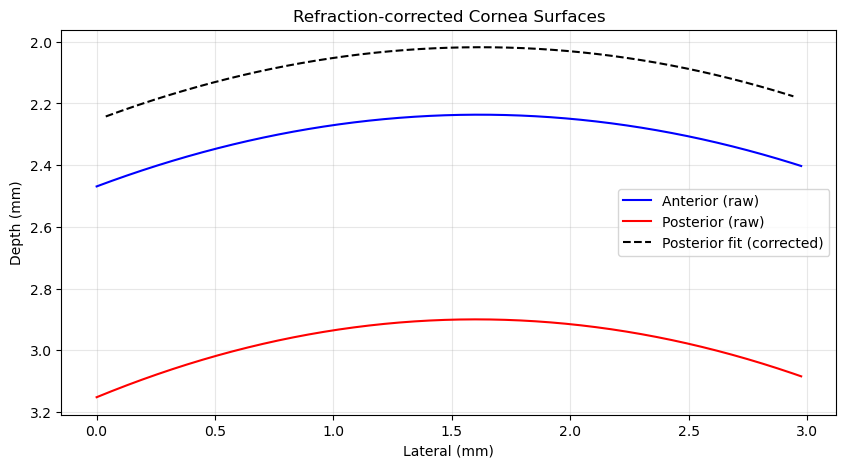

Local posterior RoC (apex): 5.526 mm


In [145]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Inputs: fitted surfaces
# -----------------------------
# x1phy : lateral coordinates (µm)
# y1_fit_phy : anterior surface (µm)
# y2_fit_phy : posterior surface (µm)
# Refractive indices
n_air = 1.0
n_cornea = 1.376

# Assume incident rays are vertical (along y)
k1 = np.array([0, -1])  # downward ray along -y

# -----------------------------
# 2) Compute normals of anterior surface
# -----------------------------
anterior_poly = np.poly1d(np.polyfit(x1phy, y1_fit_phy, 3))
posterior_poly = np.poly1d(np.polyfit(x1phy, y2_fit_phy, 3))

# derivative
dy_dx = anterior_poly.deriv(1)(x1phy)
normals = np.stack([-dy_dx, np.ones_like(dy_dx)], axis=1)
normals /= np.linalg.norm(normals, axis=1)[:, None]  # unit normals

# -----------------------------
# 3) Snell's law: refracted rays
# -----------------------------
def refract_vector(k_incident, normal, n1, n2):
    """2D vector Snell's law"""
    cos_theta_i = np.dot(-k_incident, normal)
    sin_theta_i2 = 1 - cos_theta_i**2
    sin_theta_t2 = (n1/n2)**2 * sin_theta_i2
    if sin_theta_t2 > 1.0:
        # total internal reflection (not expected for cornea)
        return None
    cos_theta_t = np.sqrt(1 - sin_theta_t2)
    k_refracted = (n1/n2) * k_incident + (cos_theta_t - (n1/n2)*cos_theta_i) * normal
    return k_refracted

k2_vectors = np.array([refract_vector(k1, n, n_air, n_cornea) for n in normals])

# -----------------------------
# 4) Compute optical distance to posterior surface
# -----------------------------
od2 = y2_fit_phy - y1_fit_phy  # optical distance in µm along vertical
gd2 = od2 / n_cornea           # geometric distance

# Compute object-space posterior points
O1 = np.stack([x1phy, y1_fit_phy], axis=1)
O2 = np.array([O1[i] + gd2[i]*k2_vectors[i] for i in range(len(O1))])

# -----------------------------
# 5) Fit corrected posterior curve
# -----------------------------
x_corr = O2[:,0]
y_corr = O2[:,1]
fit_values_corrected = np.polyfit(x_corr, y_corr, 3)
posterior_corr_poly = np.poly1d(fit_values_corrected)

# -----------------------------
# 6) Plot results
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(x1phy/1000, y1_fit_phy/1000, 'b-', label='Anterior (raw)')
plt.plot(x1phy/1000, y2_fit_phy/1000, 'r-', label='Posterior (raw)')
# plt.plot(O2[:,0]/1000, O2[:,1]/1000, 'g.', label='Posterior (corrected)')
plt.plot(x_corr/1000, posterior_corr_poly(x_corr)/1000, 'k--', label='Posterior fit (corrected)')
plt.gca().invert_yaxis()
plt.xlabel("Lateral (mm)")
plt.ylabel("Depth (mm)")
plt.title("Refraction-corrected Cornea Surfaces")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# -----------------------------
# 7) Compute RoC for corrected posterior surface
# -----------------------------
dy_dx_corr = posterior_corr_poly.deriv(1)(x_corr)
d2y_dx2_corr = posterior_corr_poly.deriv(2)(x_corr)
R_corr = ((1 + dy_dx_corr**2)**1.5) / np.abs(d2y_dx2_corr)

# Local RoC at apex
x_apex = x_corr[np.argmin(posterior_corr_poly(x_corr))]
R_apex = ((1 + posterior_corr_poly.deriv(1)(x_apex)**2)**1.5) / np.abs(posterior_corr_poly.deriv(2)(x_apex))
print(f"Local posterior RoC (apex): {R_apex/1000:.3f} mm")


Corrected anterior RoC (apex): 5.582 mm
Corrected posterior RoC (apex): 5.526 mm


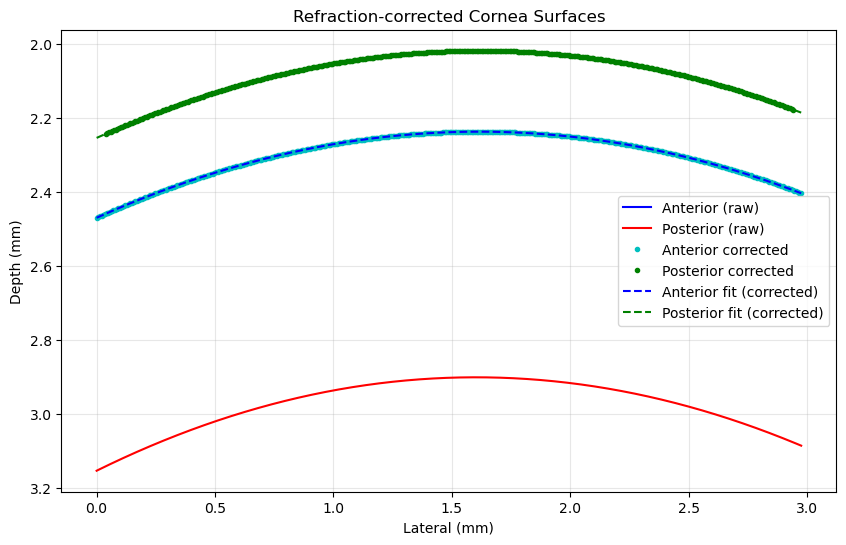

In [146]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Inputs: fitted surfaces
# -----------------------------
# x1phy : lateral coordinates (µm)
# y1_fit_phy : anterior surface (µm)
# y2_fit_phy : posterior surface (µm)
# Refractive indices
n_air = 1.0
n_cornea = 1.376

# Incident rays along vertical
k_incident = np.array([0, -1])  # along -y

# -----------------------------
# 2) Function: compute normals
# -----------------------------
def compute_normals(x, poly):
    dy_dx = poly.deriv(1)(x)
    normals = np.stack([-dy_dx, np.ones_like(dy_dx)], axis=1)
    normals /= np.linalg.norm(normals, axis=1)[:, None]
    return normals

# -----------------------------
# 3) Function: 2D vector Snell's law
# -----------------------------
def refract_vector(k_incident, normal, n1, n2):
    cos_theta_i = np.dot(-k_incident, normal)
    sin_theta_i2 = 1 - cos_theta_i**2
    sin_theta_t2 = (n1/n2)**2 * sin_theta_i2
    if sin_theta_t2 > 1.0:
        return None  # total internal reflection (not expected here)
    cos_theta_t = np.sqrt(1 - sin_theta_t2)
    k_refracted = (n1/n2) * k_incident + (cos_theta_t - (n1/n2)*cos_theta_i) * normal
    return k_refracted

# -----------------------------
# 4) Correct anterior surface (object-space)
# -----------------------------
anterior_poly = np.poly1d(np.polyfit(x1phy, y1_fit_phy, 3))
normals_anterior = compute_normals(x1phy, anterior_poly)

# For first surface, we assume incident ray from air → cornea
k2_anterior = np.array([refract_vector(k_incident, n, n_air, n_cornea) for n in normals_anterior])
O1 = np.stack([x1phy, y1_fit_phy], axis=1)  # object-space coordinates remain same for first correction

# -----------------------------
# 5) Correct posterior surface (object-space)
# -----------------------------
posterior_poly = np.poly1d(np.polyfit(x1phy, y2_fit_phy, 3))
normals_posterior = compute_normals(x1phy, posterior_poly)

# Optical distance along vertical (image space)
od2 = y2_fit_phy - y1_fit_phy
gd2 = od2 / n_cornea  # geometric distance

# Compute posterior object-space coordinates
O2 = np.array([O1[i] + gd2[i]*k2_anterior[i] for i in range(len(O1))])

# Fit corrected posterior curve
fit_values_posterior_corr = np.polyfit(O2[:,0], O2[:,1], 3)
posterior_corr_poly = np.poly1d(fit_values_posterior_corr)

# -----------------------------
# 6) Correct anterior surface using object-space approximation
# -----------------------------
# For anterior, we can also correct for optical path length (optional, small effect)
# Here just for completeness, propagate slightly along incident ray
gd1 = np.zeros_like(x1phy)  # if incident rays come from infinity, no correction needed
O1_corr = O1 + (gd1[:,None]*k2_anterior)

fit_values_anterior_corr = np.polyfit(O1_corr[:,0], O1_corr[:,1], 3)
anterior_corr_poly = np.poly1d(fit_values_anterior_corr)

# -----------------------------
# 7) Compute RoC
# -----------------------------
def compute_RoC(poly, x_array):
    dy_dx = poly.deriv(1)(x_array)
    d2y_dx2 = poly.deriv(2)(x_array)
    R = ((1 + dy_dx**2)**1.5) / np.abs(d2y_dx2)
    # apex index
    apex_idx = np.argmin(poly(x_array))
    R_apex = R[apex_idx]
    return R, R_apex

R_anterior, R_apex_anterior = compute_RoC(anterior_corr_poly, x1phy)
R_posterior, R_apex_posterior = compute_RoC(posterior_corr_poly, x1phy)

print(f"Corrected anterior RoC (apex): {R_apex_anterior/1000:.3f} mm")
print(f"Corrected posterior RoC (apex): {R_apex_posterior/1000:.3f} mm")

# -----------------------------
# 8) Plot surfaces
# -----------------------------
plt.figure(figsize=(10,6))
plt.plot(x1phy/1000, y1_fit_phy/1000, 'b-', label='Anterior (raw)')
plt.plot(x1phy/1000, y2_fit_phy/1000, 'r-', label='Posterior (raw)')
plt.plot(O1_corr[:,0]/1000, O1_corr[:,1]/1000, 'c.', label='Anterior corrected')
plt.plot(O2[:,0]/1000, O2[:,1]/1000, 'g.', label='Posterior corrected')
plt.plot(x1phy/1000, anterior_corr_poly(x1phy)/1000, 'b--', label='Anterior fit (corrected)')
plt.plot(x1phy/1000, posterior_corr_poly(x1phy)/1000, 'g--', label='Posterior fit (corrected)')
plt.gca().invert_yaxis()
plt.xlabel("Lateral (mm)")
plt.ylabel("Depth (mm)")
plt.title("Refraction-corrected Cornea Surfaces")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Anterior cornea RoC (apex): 5.582 mm
Posterior cornea RoC (apex): 5.526 mm
Lens anterior RoC (apex): 3.419 mm
Lens posterior RoC (apex): 1.289 mm
Nucleus anterior RoC (apex): 4.185 mm


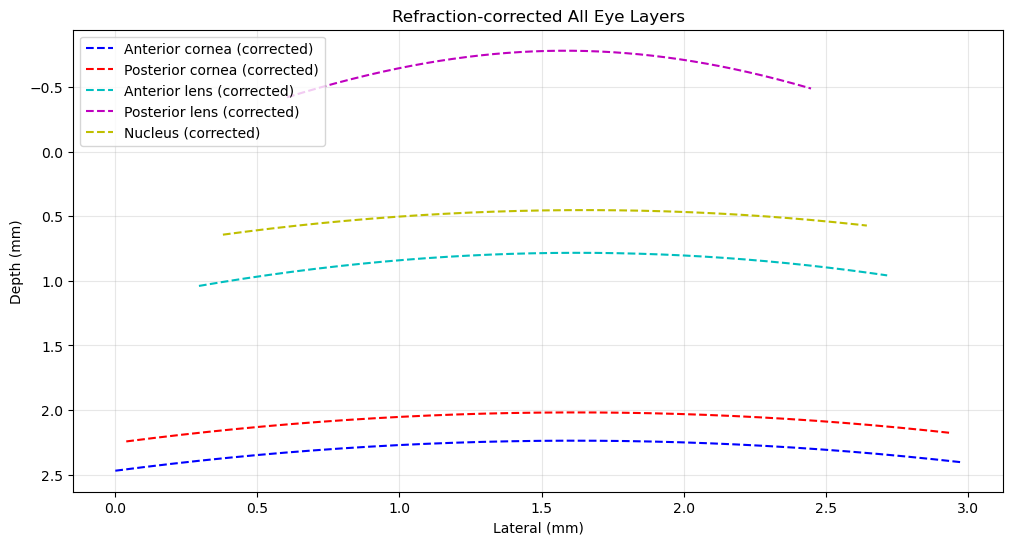

In [147]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Inputs: fitted surfaces for all layers (µm)
# -----------------------------
# x1phy, x2phy, x3phy : lateral coordinates for cornea, lens, nucleus
# y1_fit_phy, y2_fit_phy : cornea anterior/posterior
# y1_lens_fit_phy, y2_lens_fit_phy : lens anterior/posterior
# y1_nucleus_fit_phy, y2_nucleus_fit_phy : nucleus anterior/posterior
# Refractive indices
n_air = 1.0
n_cornea = 1.376
n_aqueous = 1.336
n_lens = 1.41

# Incident rays along -y
k_incident = np.array([0, -1])

# -----------------------------
# 2) Functions
# -----------------------------
def compute_normals(x, poly):
    dy_dx = poly.deriv(1)(x)
    normals = np.stack([-dy_dx, np.ones_like(dy_dx)], axis=1)
    normals /= np.linalg.norm(normals, axis=1)[:, None]
    return normals

def refract_vector(k_incident, normal, n1, n2):
    cos_theta_i = np.dot(-k_incident, normal)
    sin_theta_i2 = 1 - cos_theta_i**2
    sin_theta_t2 = (n1/n2)**2 * sin_theta_i2
    if sin_theta_t2 > 1.0:
        return None  # total internal reflection
    cos_theta_t = np.sqrt(1 - sin_theta_t2)
    k_refracted = (n1/n2) * k_incident + (cos_theta_t - (n1/n2)*cos_theta_i) * normal
    return k_refracted

def propagate_surface(O_prev, k_prev, y_prev, y_curr, n_curr):
    od = y_curr - y_prev
    gd = od / n_curr
    O_curr = np.array([O_prev[i] + gd[i]*k_prev[i] for i in range(len(O_prev))])
    return O_curr

def fit_poly(x, y, deg=3):
    mask = ~np.isnan(y)
    return np.poly1d(np.polyfit(x[mask], y[mask], deg))

def compute_RoC(poly, x_array):
    dy_dx = poly.deriv(1)(x_array)
    d2y_dx2 = poly.deriv(2)(x_array)
    R = ((1 + dy_dx**2)**1.5) / np.abs(d2y_dx2)
    apex_idx = np.argmin(poly(x_array))
    R_apex = R[apex_idx]
    return R, R_apex

# -----------------------------
# 3) Correct cornea surfaces
# -----------------------------
# Anterior cornea
anterior_poly = fit_poly(x1phy, y1_fit_phy)
normals_anterior = compute_normals(x1phy, anterior_poly)
k2_anterior = np.array([refract_vector(k_incident, n, n_air, n_cornea) for n in normals_anterior])
O1_corr = np.stack([x1phy, y1_fit_phy], axis=1)  # object-space anterior

# Posterior cornea
posterior_poly = fit_poly(x1phy, y2_fit_phy)
O2_corr = propagate_surface(O1_corr, k2_anterior, y1_fit_phy, y2_fit_phy, n_cornea)
posterior_corr_poly = fit_poly(O2_corr[:,0], O2_corr[:,1])

# -----------------------------
# 4) Correct lens surfaces
# -----------------------------
# Lens anterior
lens_anterior_poly = fit_poly(x2phy, y1_lens_fit_phy)
normals_lens_anterior = compute_normals(x2phy, lens_anterior_poly)
k_lens_anterior = np.array([refract_vector(k2_anterior[i], normals_lens_anterior[i], n_cornea, n_lens) 
                            for i in range(len(x2phy))])
O3_corr = propagate_surface(O2_corr, k_lens_anterior, y2_fit_phy, y1_lens_fit_phy, n_lens)
lens_anterior_corr_poly = fit_poly(O3_corr[:,0], O3_corr[:,1])

# Lens posterior / nucleus
lens_posterior_poly = fit_poly(x2phy, y2_lens_fit_phy)
O4_corr = propagate_surface(O3_corr, k_lens_anterior, y1_lens_fit_phy, y2_lens_fit_phy, n_lens)
lens_posterior_corr_poly = fit_poly(O4_corr[:,0], O4_corr[:,1])

# -----------------------------
# 5) Correct nucleus
# -----------------------------
nucleus_poly = fit_poly(x3phy, y1_nucleus_fit_phy)
normals_nucleus = compute_normals(x3phy, nucleus_poly)
k_nucleus = np.array([refract_vector(k_lens_anterior[i], normals_nucleus[i], n_lens, n_lens) 
                      for i in range(len(x3phy))])
O5_corr = propagate_surface(O4_corr, k_nucleus, y2_lens_fit_phy, y1_nucleus_fit_phy, n_lens)
nucleus_corr_poly = fit_poly(O5_corr[:,0], O5_corr[:,1])

# -----------------------------
# 6) Compute RoC for all surfaces
# -----------------------------
R_anterior, R_apex_anterior = compute_RoC(anterior_poly, x1phy)
R_posterior, R_apex_posterior = compute_RoC(posterior_corr_poly, x1phy)
R_lens_anterior, R_apex_lens_anterior = compute_RoC(lens_anterior_corr_poly, x2phy)
R_lens_posterior, R_apex_lens_posterior = compute_RoC(lens_posterior_corr_poly, x2phy)
R_nucleus, R_apex_nucleus = compute_RoC(nucleus_corr_poly, x3phy)

print(f"Anterior cornea RoC (apex): {R_apex_anterior/1000:.3f} mm")
print(f"Posterior cornea RoC (apex): {R_apex_posterior/1000:.3f} mm")
print(f"Lens anterior RoC (apex): {R_apex_lens_anterior/1000:.3f} mm")
print(f"Lens posterior RoC (apex): {R_apex_lens_posterior/1000:.3f} mm")
print(f"Nucleus anterior RoC (apex): {R_apex_nucleus/1000:.3f} mm")

# -----------------------------
# 7) Plot all surfaces
# -----------------------------
plt.figure(figsize=(12,6))
# plt.plot(x1phy/1000, y1_fit_phy/1000, 'b-', label='Anterior cornea (raw)')
plt.plot(O1_corr[:,0]/1000, O1_corr[:,1]/1000, 'b--', label='Anterior cornea (corrected)')

# plt.plot(x1phy/1000, y2_fit_phy/1000, 'r-', label='Posterior cornea (raw)')
plt.plot(O2_corr[:,0]/1000, O2_corr[:,1]/1000, 'r--', label='Posterior cornea (corrected)')

# plt.plot(x2phy/1000, y1_lens_fit_phy/1000, 'c-', label='Anterior lens (raw)')
plt.plot(O3_corr[:,0]/1000, O3_corr[:,1]/1000, 'c--', label='Anterior lens (corrected)')

# plt.plot(x2phy/1000, y2_lens_fit_phy/1000, 'm-', label='Posterior lens (raw)')
plt.plot(O4_corr[:,0]/1000, O4_corr[:,1]/1000, 'm--', label='Posterior lens (corrected)')

# plt.plot(x3phy/1000, y1_nucleus_fit_phy/1000, 'y-', label='Nucleus (raw)')
plt.plot(O5_corr[:,0]/1000, O5_corr[:,1]/1000, 'y--', label='Nucleus (corrected)')

plt.gca().invert_yaxis()
plt.xlabel("Lateral (mm)")
plt.ylabel("Depth (mm)")
plt.title("Refraction-corrected All Eye Layers")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## RoC calculation

In [155]:
xc1, yc1, radius1 = fit_circle(x1phy, y1phy,)
print(f"Estimated circle center before curve fit: ({xc1:.2f}, {yc1:.2f}), RoC Cornea 1: {radius1/1000:.2f} mm")

xc2, yc2, radius2 = fit_circle(x1phy, y1_fit_phy,)
print(f"Estimated circle center before curve fit: ({xc2:.2f}, {yc2:.2f}), RoC Cornea 1: {radius2/1000:.2f} mm")
xc2, yc22, radius22 = fit_circle(x1phy, y2_fit_phy,)
print(f"Estimated circle center before curve fit: ({xc2:.2f}, {yc22:.2f}), RoC Cornea 2: {radius22/1000:.2f} mm")

xc2, yc2, radius2 = fit_circle(x1phy, y1_lens_fit_phy,)
print(f"Estimated circle center before curve fit: ({xc2:.2f}, {yc2:.2f}), RoC Lens 1: {radius2/1000:.2f} mm")
xc2, yc22, radius22 = fit_circle(x1phy, y2_lens_fit_phy,)
print(f"Estimated circle center before curve fit: ({xc2:.2f}, {yc22:.2f}), RoC Lens 2: {radius22/1000:.2f} mm")

xc2, yc2, radius2 = fit_circle(x1phy, y1_nucleus_fit_phy,)
print(f"Estimated circle center before curve fit: ({xc2:.2f}, {yc2:.2f}), RoC Nucleus 1: {radius2/1000:.2f} mm")
xc2, yc22, radius22 = fit_circle(x1phy, y2_nucleus_fit_phy,)
print(f"Estimated circle center before curve fit: ({xc2:.2f}, {yc22:.2f}), RoC Nucleus 2: {radius22/1000:.2f} mm")

Estimated circle center before curve fit: (1610.30, 7816.95), RoC Cornea 1: 5.58 mm
Estimated circle center before curve fit: (1612.50, 7914.46), RoC Cornea 1: 5.68 mm
Estimated circle center before curve fit: (1601.57, 8090.09), RoC Cornea 2: 5.19 mm
Estimated circle center before curve fit: (1497.07, 17038.38), RoC Lens 1: 9.69 mm
Estimated circle center before curve fit: (1440.87, 9292.35), RoC Lens 2: 3.69 mm
Estimated circle center before curve fit: (1529.69, 12057.87), RoC Nucleus 1: 3.52 mm
Estimated circle center before curve fit: (1465.87, 9735.18), RoC Nucleus 2: 2.24 mm


In [137]:
anterior_poly = np.poly1d(np.polyfit(x1phy, y1_fit_phy, 3))
posterior_poly = np.poly1d(np.polyfit(x1phy, y2_fit_phy, 3))

# Compute derivatives
dp = anterior_poly.deriv(1)   # first derivative
ddp = anterior_poly.deriv(2)  # second derivative

# Compute RoC along domain
xs = np.linspace(x1phy.min(), x1phy.max(), 1000)
R_vals = ((1 + dp(xs)**2)**1.5) / np.abs(ddp(xs))

# Apex location (minimum y)
x_apex = xs[np.argmin(anterior_poly(xs))]
R_apex = ((1 + dp(x_apex)**2)**1.5) / np.abs(ddp(x_apex))

print(f"Local radius of curvature at apex: {R_apex/1000:.3f} mm")


Local radius of curvature at apex: 5.582 mm


In [138]:
print(f"x range: {x1phy.min()}–{x1phy.max()} µm, y range: {y1_fit_phy.min()}–{y1_fit_phy.max()} µm")


x range: 0.0–2974.8999999999996 µm, y range: 2226.731194658734–2459.2516755261076 µm


In [139]:
def fit_circle_kasa(x, y):
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    A = np.hstack([2*x, 2*y, np.ones_like(x)])
    b = x**2 + y**2
    p, *_ = np.linalg.lstsq(A, b, rcond=None)
    a = p[0,0]
    b_c = p[1,0]
    c = p[2,0]
    R = np.sqrt(a*a + b_c*b_c + c)
    return a, b_c, R

# Use central ±1 mm (1000 µm) for more robust clinical estimate
center_x = (x1phy.min() + x1phy.max())/2
mask = (x1phy >= (center_x - 1000)) & (x1phy <= (center_x + 1000)) & (~np.isnan(y1_fit_phy))
x_fit = x1phy[mask]
y_fit = y1_fit_phy[mask]

a,b,R_global = fit_circle_kasa(x_fit, y_fit)
print(f"Circle fit radius: {R_global/1000:.3f} mm")



Circle fit radius: 5.631 mm


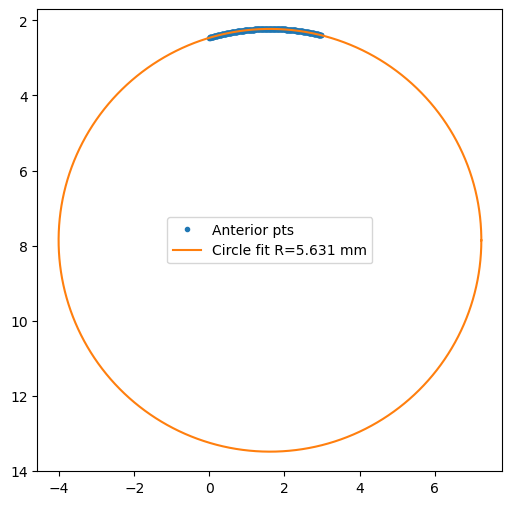

In [140]:
theta = np.linspace(0, 2*np.pi, 400)
xc = a + R_global * np.cos(theta)
yc = b + R_global * np.sin(theta)

plt.figure(figsize=(6,6))
plt.plot(x1phy/1000, y1_fit_phy/1000, '.', label='Anterior pts')
plt.plot(xc/1000, yc/1000, '-', label=f'Circle fit R={R_global/1000:.3f} mm')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.legend()
plt.show()


## Ray Tracing

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

def surface_intersection(ray_p, ray_dir, surface_fn, t_min=1e-6, t_max=5e4):
    """
    Find intersection parameter t for ray r(t) = ray_p + t * ray_dir with y = surface_fn(x).
    Returns (t, x_int, y_int) or (None, None, None) if no intersection found in [t_min, t_max].
    """
    # If ray_dir[0] == 0 (vertical ray), solve directly:
    if abs(ray_dir[0]) < 1e-12:
        x0 = ray_p[0]
        y_surf = surface_fn(x0)
        # solve t = (y_surf - ray_p[1]) / ray_dir[1]
        if abs(ray_dir[1]) < 1e-12:
            return None, None, None
        t = (y_surf - ray_p[1]) / ray_dir[1]
        if t_min < t < t_max:
            return t, x0, y_surf
        else:
            return None, None, None

    # Otherwise, define f(t) = ray_y(t) - surface_fn(ray_x(t)), want f(t)=0
    def f(t):
        x_t = ray_p[0] + t * ray_dir[0]
        y_t = ray_p[1] + t * ray_dir[1]
        return y_t - surface_fn(x_t)

    # Make a bracket search for sign change in f(t). Try exponential expansion
    a = t_min
    fa = f(a)
    b = a * 2 if a>0 else 1.0
    fb = f(b)
    # expand until sign change or until t_max
    iter_count = 0
    while fa * fb > 0 and b < t_max and iter_count < 80:
        a = b
        fa = fb
        b = b * 2 + 1.0
        fb = f(b)
        iter_count += 1

    if fa * fb > 0:
        # Could not bracket root — return None
        return None, None, None

    try:
        t_root = brentq(f, a, b, maxiter=100)
        x_root = ray_p[0] + t_root * ray_dir[0]
        y_root = ray_p[1] + t_root * ray_dir[1]
        return t_root, x_root, y_root
    except Exception as e:
        return None, None, None

def surface_normal_at_x(surface_fn, x, eps=1e-6):
    """Return unit normal vector at surface point (x, surface_fn(x)).
       For surface y=f(x), tangent = (1, f'), normal = (-f', 1)."""
    # numerical derivative
    f_x1 = surface_fn(x + eps)
    f_x0 = surface_fn(x - eps)
    fprime = (f_x1 - f_x0) / (2*eps)
    tangent = np.array([1.0, fprime])
    normal = np.array([-fprime, 1.0])
    normal = normal / np.linalg.norm(normal)
    return normal, fprime

def refract_vector(d, n, n1, n2):
    """Vector form Snell's law. d incoming (unit), n is unit normal pointing OUT of incident medium
       (i.e., should point towards incident side). Returns refracted (unit) or None if TIR."""
    d = d / np.linalg.norm(d)
    n = n / np.linalg.norm(n)
    cos_i = -np.dot(n, d)   # assume n points from medium2 into medium1; adjust sign convention carefully
    # clamp
    if cos_i < -1: cos_i = -1
    if cos_i > 1: cos_i = 1
    sin_t2 = (n1 / n2)**2 * max(0.0, 1 - cos_i**2)
    if sin_t2 > 1.0:
        return None  # Total internal reflection
    cos_t = np.sqrt(max(0.0, 1 - sin_t2))
    t = (n1 / n2) * d + ((n1 / n2) * cos_i - cos_t) * n
    t = t / np.linalg.norm(t)
    return t

# ---------------------------
# 5) Main ray tracing routine
# ---------------------------

def trace_rays(anterior_fn, posterior_fn, x_span, num_rays=41,
               ray_height_above=2000.0, n_air=1.0003, n_cornea=1.376, n_aqueous=1.336):
    """
    Traces rays from air into cornea (anterior_fn -> posterior_fn).
    Units: use same units as functions (assumed µm here).
    - x_span: (x_min, x_max) lateral domain for ray origins (µm)
    - ray_height_above: vertical start offset above the anterior surface (µm)
    Returns list of ray path segments for plotting.
    """
    x_min, x_max = x_span
    x_rays = np.linspace(x_min, x_max, num_rays)

    ray_segments = []  # each element: list of points [(x0,y0),(x1,y1),...]
    for x0 in x_rays:
        # start point: above the surface at ray_height_above from the local surface y
        y_surface_at_x0 = anterior_fn(x0)
        p0 = np.array([x0, y_surface_at_x0 + ray_height_above])  # start point (µm)
        d0 = np.array([0.0, -1.0])  # incoming ray direction (unit) pointing downward

        seg_pts = [p0.copy()]

        # 1) Find intersection with anterior surface
        tA, xiA, yiA = surface_intersection(p0, d0, anterior_fn)
        if tA is None:
            # no intersection -> skip this ray
            continue
        P_A = np.array([xiA, yiA])
        seg_pts.append(P_A.copy())

        # 2) Compute normal at anterior (pointing out of cornea into air)
        nA, fprimeA = surface_normal_at_x(anterior_fn, xiA)
        # We must ensure normal points toward incident medium (air above surface).
        # For our geometry, normal computed as [-f',1]/|...| points roughly upwards if surface is concave.
        # If dot(nA, d0) > 0 then normal is pointing in same half-space as ray, flip it.
        if np.dot(nA, d0) > 0:
            nA = -nA

        # 3) Refract at anterior (air -> cornea)
        d1 = refract_vector(d0, nA, n_air, n_cornea)
        if d1 is None:
            # TIR at anterior (rare for air->cornea). Stop ray.
            ray_segments.append(seg_pts)
            continue

        # propagate slightly inside to avoid re-hitting the same point
        P_inside = P_A + d1 * 1e-3
        seg_pts.append(P_inside.copy())

        # 4) Find intersection with posterior surface (ray inside cornea)
        tP, xiP, yiP = surface_intersection(P_inside, d1, posterior_fn)
        if tP is None:
            # no posterior intersection (maybe ray exits elsewhere) -> append segment and continue
            # extend segment for visualization
            seg_pts.append(P_inside + d1 * 2000.0)
            ray_segments.append(seg_pts)
            continue

        P_P = np.array([xiP, yiP])
        seg_pts.append(P_P.copy())

        # 5) Compute normal at posterior
        nP, fprimeP = surface_normal_at_x(posterior_fn, xiP)
        # For posterior, normal should point into cornea (towards incident medium inside cornea)
        if np.dot(nP, d1) > 0:
            nP = -nP

        # 6) Refract at posterior (cornea -> aqueous)
        d2 = refract_vector(d1, nP, n_cornea, n_aqueous)
        if d2 is None:
            # TIR at posterior: reflect (optional) — here we stop
            ray_segments.append(seg_pts)
            continue

        # append small inside-to-out point and an exit extension
        P_after = P_P + d2 * 1e-3
        seg_pts.append(P_after.copy())
        seg_pts.append(P_after + d2 * 3000.0)  # extend for visualization

        ray_segments.append(seg_pts)

    return x_rays, ray_segments

In [48]:
n_air = 1.000
n_cornea = 1.3665
n_aqueous = 1.3266
n_lens = 1.3749
n_nucleus = 1.3947
n_vitreous = 1.327

num_rays = 100

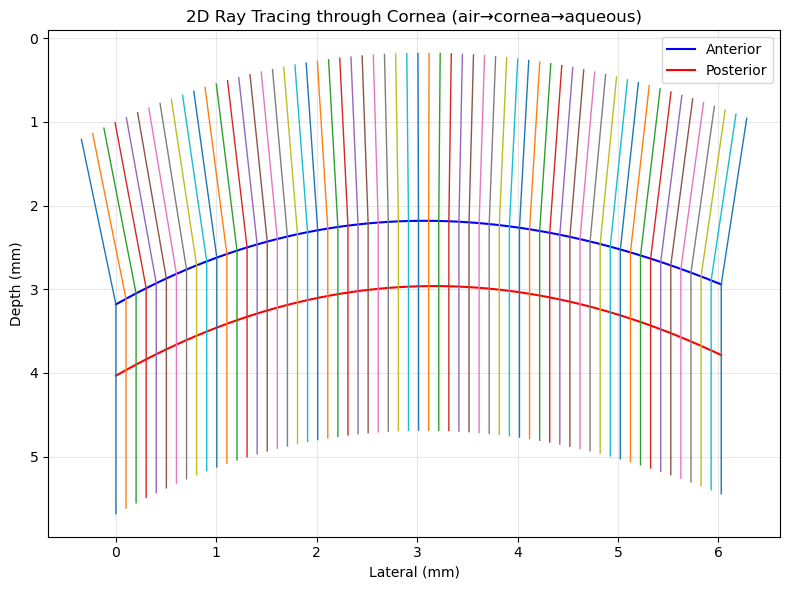

In [50]:
anterior_poly = np.poly1d(np.polyfit(x1phy, y1_fit_phy, 3))
posterior_poly = np.poly1d(np.polyfit(x1phy, y2_fit_phy, 3))
try:
    anterior_poly  # check if provided
    posterior_poly
except NameError:
    raise RuntimeError("Please assign `anterior_poly` and `posterior_poly` (np.poly1d) from your fitted data before running.")

# choose lateral domain from your fitted x array
# If you have x1phy array: x_min = x1phy.min(); x_max = x1phy.max()
x_min = x1phy.min()
x_max = x1phy.max()

# trace rays
x_rays, segments = trace_rays(anterior_poly, posterior_poly, (x_min, x_max),
                                num_rays=61,
                                ray_height_above=2500.0,  # µm above surface
                                n_air=n_air, n_cornea=n_cornea, n_aqueous=n_aqueous)

# ---------------------------
# 7) Plot result (convert to mm for nicer axes)
# ---------------------------
plt.figure(figsize=(8,6))
# plot surfaces
xs = np.linspace(x_min, x_max, 800)
plt.plot(xs/1000.0, anterior_poly(xs)/1000.0, 'b', label='Anterior')
plt.plot(xs/1000.0, posterior_poly(xs)/1000.0, 'r', label='Posterior')

# plot rays
for seg in segments:
    seg = np.array(seg)
    plt.plot(seg[:,0]/1000.0, seg[:,1]/1000.0, '-', linewidth=1)

plt.xlabel("Lateral (mm)")
plt.ylabel("Depth (mm)")
plt.title("2D Ray Tracing through Cornea (air→cornea→aqueous)")
plt.gca().invert_yaxis()  # so corneal surface (top) appears at top
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

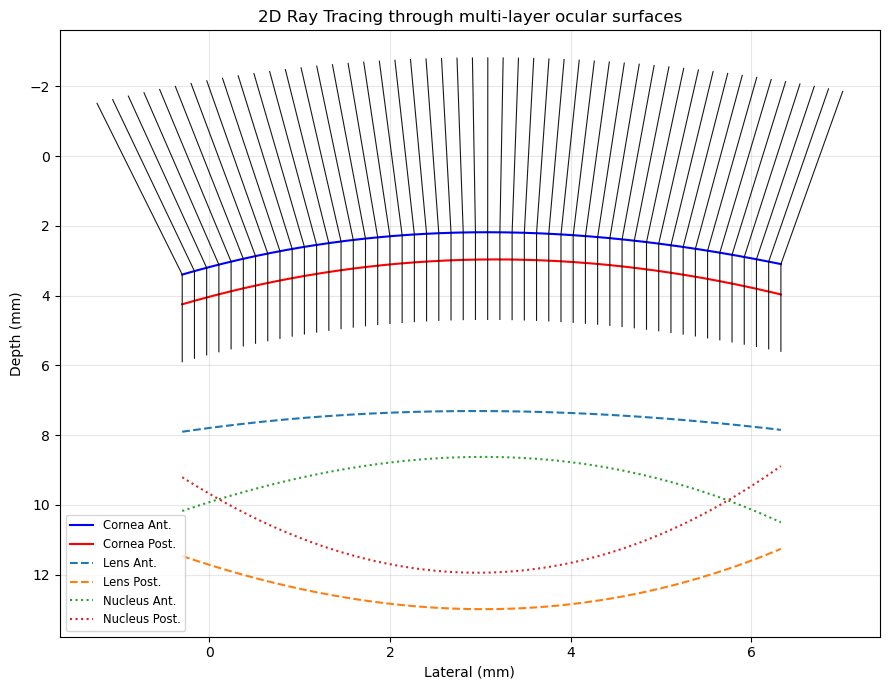

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# ---------------------------
# 0) Optical indices 
# ---------------------------
n_air = 1.000
n_cornea = 1.3665
n_aqueous = 1.3266
n_lens = 1.3749
n_nucleus = 1.3947
n_vitreous = 1.327

# ---------------------------
# 1) Create poly1d surfaces from your fitted arrays (if not already created)
# You should have arrays from your previous steps:
# x1phy, y1_fit_phy, y2_fit_phy  (cornea anterior/posterior)
# x2phy, y1_lens_fit_phy, y2_lens_fit_phy (lens anterior/posterior)
# x3phy, y1_nucleus_fit_phy, y2_nucleus_fit_phy (nucleus anterior/posterior)
# All in same units (µm).
# ---------------------------

def _make_poly_from_arrays(x_arr_name, y_arr_name):
    # helper to check variable exists and make poly1d
    if x_arr_name in globals() and y_arr_name in globals():
        x_arr = globals()[x_arr_name]
        y_arr = globals()[y_arr_name]
        mask = ~np.isnan(x_arr) & ~np.isnan(y_arr)
        if mask.sum() < 5:
            raise RuntimeError(f"Not enough valid points for {y_arr_name}")
        coeffs = np.polyfit(x_arr[mask], y_arr[mask], 3)
        return np.poly1d(coeffs)
    else:
        return None

# try to obtain the poly1d surfaces (if arrays exist)
anterior_cornea_poly = _make_poly_from_arrays('x1phy', 'y1_fit_phy')     or globals().get('anterior_poly', None)
posterior_cornea_poly = _make_poly_from_arrays('x1phy', 'y2_fit_phy')    or globals().get('posterior_poly', None)

anterior_lens_poly = _make_poly_from_arrays('x2phy', 'y1_lens_fit_phy')  or globals().get('anterior_lens_poly', None)
posterior_lens_poly = _make_poly_from_arrays('x2phy', 'y2_lens_fit_phy') or globals().get('posterior_lens_poly', None)

anterior_nucleus_poly = _make_poly_from_arrays('x3phy', 'y1_nucleus_fit_phy') or globals().get('anterior_nucleus_poly', None)
posterior_nucleus_poly = _make_poly_from_arrays('x3phy', 'y2_nucleus_fit_phy') or globals().get('posterior_nucleus_poly', None)

# require cornea surfaces at minimum
if anterior_cornea_poly is None or posterior_cornea_poly is None:
    raise RuntimeError("Please provide cornea surface poly1d (anterior & posterior) or arrays x1phy,y1_fit_phy,y2_fit_phy")

# if lens/nucleus polys missing, ray tracer will skip those interfaces (works modularly)
# ---------------------------
# 2) Geometry helpers (intersection, normals, refraction)
# ---------------------------

def surface_intersection(ray_p, ray_dir, surface_fn, t_min=1e-6, t_max=1e6):
    """
    Find t such that ray_p + t*ray_dir intersects y = surface_fn(x).
    Returns (t, x_int, y_int) or (None,None,None).
    """
    # vertical ray (dx ~ 0) -> solve directly
    if abs(ray_dir[0]) < 1e-12:
        x0 = ray_p[0]
        y_surf = surface_fn(x0)
        if abs(ray_dir[1]) < 1e-12:
            return None, None, None
        t = (y_surf - ray_p[1]) / ray_dir[1]
        if t_min < t < t_max:
            return t, x0, y_surf
        return None, None, None

    def f(t):
        x_t = ray_p[0] + t * ray_dir[0]
        y_t = ray_p[1] + t * ray_dir[1]
        return y_t - surface_fn(x_t)

    # bracket search for root
    a = t_min
    fa = f(a)
    b = a + 1.0
    fb = f(b)
    iter_count = 0
    while fa * fb > 0 and b < t_max and iter_count < 80:
        a = b
        fa = fb
        b = b * 2 + 1.0
        fb = f(b)
        iter_count += 1

    if fa * fb > 0:
        return None, None, None

    try:
        t_root = brentq(f, a, b, maxiter=200)
        x_root = ray_p[0] + t_root * ray_dir[0]
        y_root = ray_p[1] + t_root * ray_dir[1]
        return t_root, x_root, y_root
    except Exception:
        return None, None, None

def surface_normal_at_x(surface_fn, x, eps=1e-6):
    """
    For y = f(x), tangent ~ (1, f'), normal ~ (-f', 1). Returns unit normal pointing roughly "upwards".
    """
    f_x1 = surface_fn(x + eps)
    f_x0 = surface_fn(x - eps)
    fprime = (f_x1 - f_x0) / (2 * eps)
    normal = np.array([-fprime, 1.0])
    normal = normal / np.linalg.norm(normal)
    return normal, fprime

def refract_vector(d, n, n1, n2):
    """
    Vector Snell's law. d = incoming unit direction, n = unit normal.
    n should be oriented such that it points into the incident medium (i.e., opposite side from interior).
    Returns unit refracted direction or None if TIR.
    """
    d = d / np.linalg.norm(d)
    n = n / np.linalg.norm(n)
    cos_i = -np.dot(n, d)
    cos_i = np.clip(cos_i, -1.0, 1.0)
    sin_t2 = (n1 / n2)**2 * max(0.0, 1 - cos_i**2)
    if sin_t2 > 1.0:
        return None
    cos_t = np.sqrt(max(0.0, 1 - sin_t2))
    t = (n1 / n2) * d + ((n1 / n2) * cos_i - cos_t) * n
    return t / np.linalg.norm(t)

# ---------------------------
# 3) Multi-interface tracer
# ---------------------------

def trace_through_interfaces(interfaces, x_span, num_rays=41, ray_height_above=2000.0):
    """
    interfaces: list of tuples (surface_fn, n_in, n_out)
      - surfaces must be ordered along ray path (first surface encountered first)
    x_span: (x_min, x_max) in same units as surfaces (µm)
    Returns: x_rays, list_of_ray_segments (each segment is list of points [ (x,y), ... ])
    """
    x_min, x_max = x_span
    x_rays = np.linspace(x_min, x_max, num_rays)
    all_ray_segments = []

    for x0 in x_rays:
        seg_pts = []
        # start point: place ray_height_above above first surface locally
        surf0 = interfaces[0][0]
        y0_surface = surf0(x0)
        p = np.array([x0, y0_surface + ray_height_above])  # start
        d = np.array([0.0, -1.0])  # incoming direction (downwards)
        seg_pts.append(p.copy())

        valid_ray = True

        for surf_fn, n_in, n_out in interfaces:
            # find intersection
            t, xi, yi = surface_intersection(p, d, surf_fn)
            if t is None:
                # if no intersection, extend ray for visualization and stop
                seg_pts.append((p + d * 5000.0).copy())
                valid_ray = False
                break

            P_int = np.array([xi, yi])
            seg_pts.append(P_int.copy())

            # compute normal and orient it toward incident medium
            n_vec, _ = surface_normal_at_x(surf_fn, xi)
            # ensure normal points against the ray direction (toward incident medium)
            if np.dot(n_vec, d) > 0:
                n_vec = -n_vec

            # refract
            d_new = refract_vector(d, n_vec, n_in, n_out)
            if d_new is None:
                # total internal reflection: reflect direction and continue or stop
                # here we append reflection segment and stop tracing further interfaces
                # reflect: r = d - 2*(d·n)*n
                r = d - 2 * np.dot(d, n_vec) * n_vec
                seg_pts.append((P_int + r * 1000.0).copy())
                valid_ray = False
                break

            # step a bit along refracted direction to avoid self-intersection numerical issues
            p = P_int + d_new * 1e-3
            d = d_new
            # continue to next interface

        # after all interfaces processed or stopped, extend final ray a bit for visualization
        if valid_ray:
            seg_pts.append((p + d * 3000.0).copy())

        all_ray_segments.append(seg_pts)

    return x_rays, all_ray_segments

# ---------------------------
# 4) Build the ordered interface list (only include surfaces that exist)
# Order must be the actual physical ordering encountered by incoming rays.
# ---------------------------
interfaces = []
# cornea anterior (air -> cornea)
interfaces.append((anterior_cornea_poly, n_air, n_cornea))
# cornea posterior (cornea -> aqueous)
interfaces.append((posterior_cornea_poly, n_cornea, n_aqueous))

# lens interfaces if available (aqueous -> lens, lens -> nucleus or lens -> aqueous depending)
if anterior_lens_poly is not None and posterior_lens_poly is not None:
    interfaces.append((anterior_lens_poly, n_aqueous, n_lens))
    interfaces.append((posterior_lens_poly, n_lens, n_nucleus))
elif anterior_lens_poly is not None:
    # single lens anterior surface only (aqueous -> lens)
    interfaces.append((anterior_lens_poly, n_aqueous, n_lens))

# nucleus interfaces if available
if anterior_nucleus_poly is not None and posterior_nucleus_poly is not None:
    interfaces.append((anterior_nucleus_poly, n_lens, n_nucleus))
    interfaces.append((posterior_nucleus_poly, n_nucleus, n_aqueous))  # often nucleus->vitreous/aqueous — adjust if needed
elif anterior_nucleus_poly is not None:
    interfaces.append((anterior_nucleus_poly, n_lens, n_nucleus))

# ---------------------------
# 5) Choose lateral domain from available x arrays (fall back to cornea domain)
# ---------------------------
# Prefer intersection of domains if x arrays are present; else use cornea x1phy
x_min = None
x_max = None
if 'x1phy' in globals():
    x_min = x1phy.min(); x_max = x1phy.max()
elif 'x2phy' in globals():
    x_min = x2phy.min(); x_max = x2phy.max()
elif 'x3phy' in globals():
    x_min = x3phy.min(); x_max = x3phy.max()
else:
    raise RuntimeError("No x domain arrays found (x1phy/x2phy/x3phy). Set x_min/x_max manually.")

# expand a little margin
x_pad = (x_max - x_min) * 0.05
x_span = (x_min - x_pad, x_max + x_pad)

# ---------------------------
# 6) Trace rays
# ---------------------------
x_rays, ray_segments = trace_through_interfaces(interfaces, x_span, num_rays=50, ray_height_above=2500.0)

# ---------------------------
# 7) Plot results (convert µm -> mm for nicer axis ticks)
# ---------------------------
plt.figure(figsize=(9,7))

# plot all surfaces for visual reference using a common xs
xs = np.linspace(x_span[0], x_span[1], 1000)
if anterior_cornea_poly is not None:
    plt.plot(xs/1000.0, anterior_cornea_poly(xs)/1000.0, 'b', label='Cornea Ant.')
if posterior_cornea_poly is not None:
    plt.plot(xs/1000.0, posterior_cornea_poly(xs)/1000.0, 'r', label='Cornea Post.')
if anterior_lens_poly is not None:
    plt.plot(xs/1000.0, anterior_lens_poly(xs)/1000.0, '--', label='Lens Ant.')
if posterior_lens_poly is not None:
    plt.plot(xs/1000.0, posterior_lens_poly(xs)/1000.0, '--', label='Lens Post.')
if anterior_nucleus_poly is not None:
    plt.plot(xs/1000.0, anterior_nucleus_poly(xs)/1000.0, ':', label='Nucleus Ant.')
if posterior_nucleus_poly is not None:
    plt.plot(xs/1000.0, posterior_nucleus_poly(xs)/1000.0, ':', label='Nucleus Post.')

# plot rays
for seg in ray_segments:
    seg_np = np.array(seg)
    plt.plot(seg_np[:,0]/1000.0, seg_np[:,1]/1000.0, '-', color='k', linewidth=0.8, alpha=0.9)

plt.xlabel("Lateral (mm)")
plt.ylabel("Depth (mm)")
plt.title("2D Ray Tracing through multi-layer ocular surfaces")
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

# ---------------------------
# 8) (Optional) Return numerical data for further analysis
# ---------------------------
# `ray_segments` contains per-ray point lists. You can analyze intersections, compute approximate focus, etc.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.2269175].


Sample 1: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


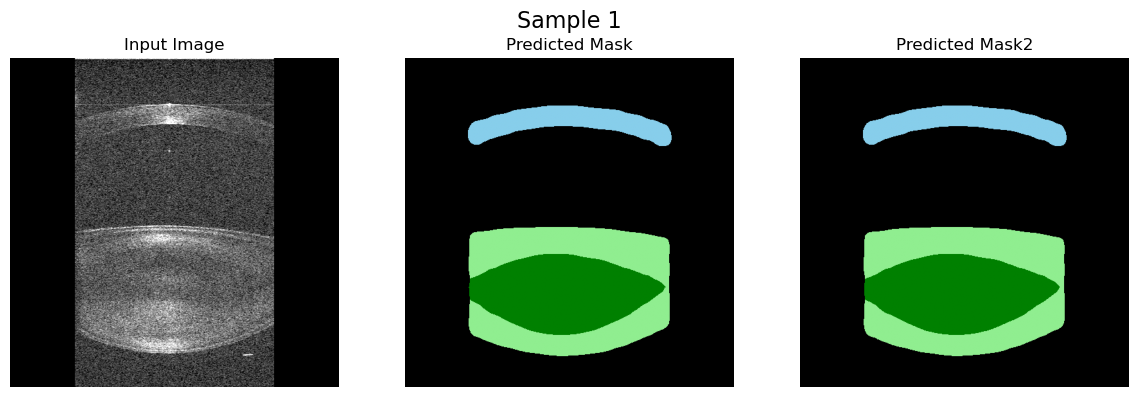

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.474205].


Sample 2: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


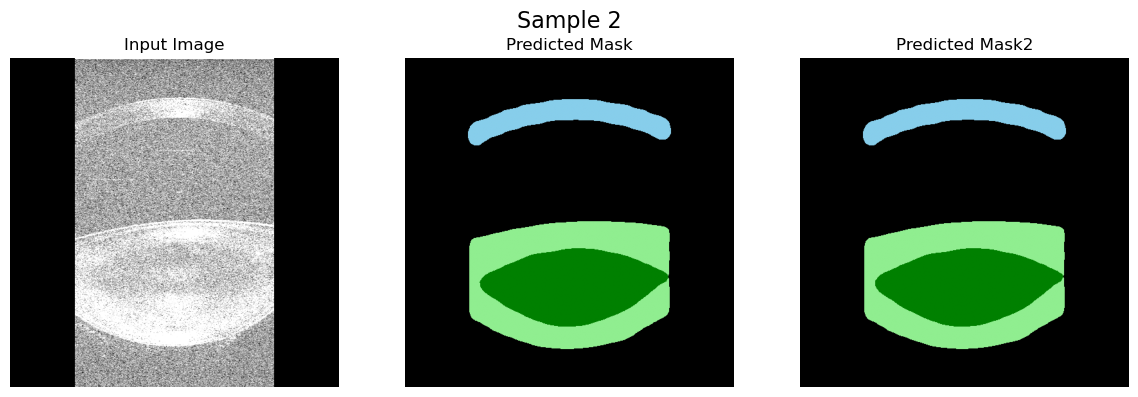

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.3917758].


Sample 3: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


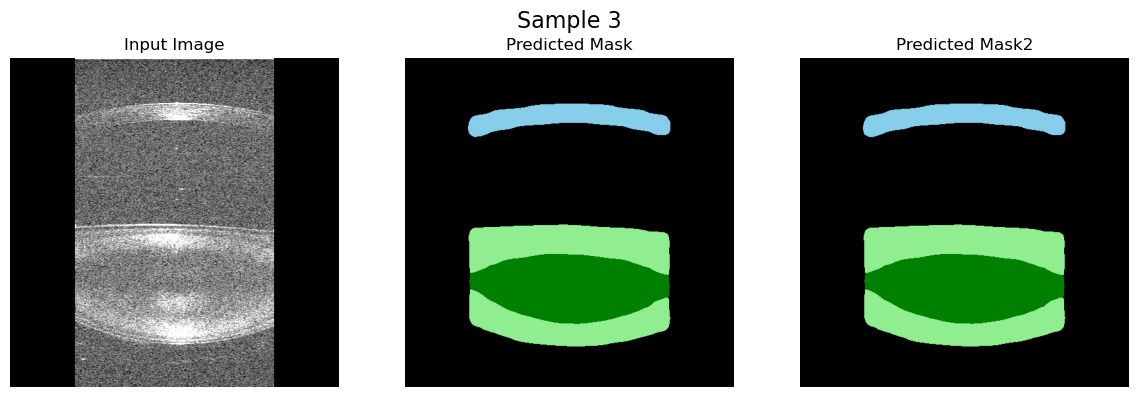

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.0208445].


Sample 4: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


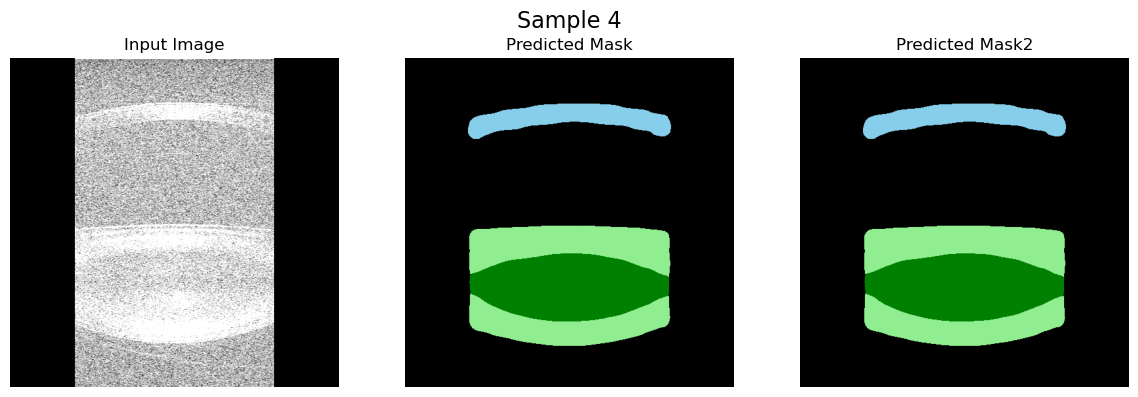

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.3711686].


Sample 5: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


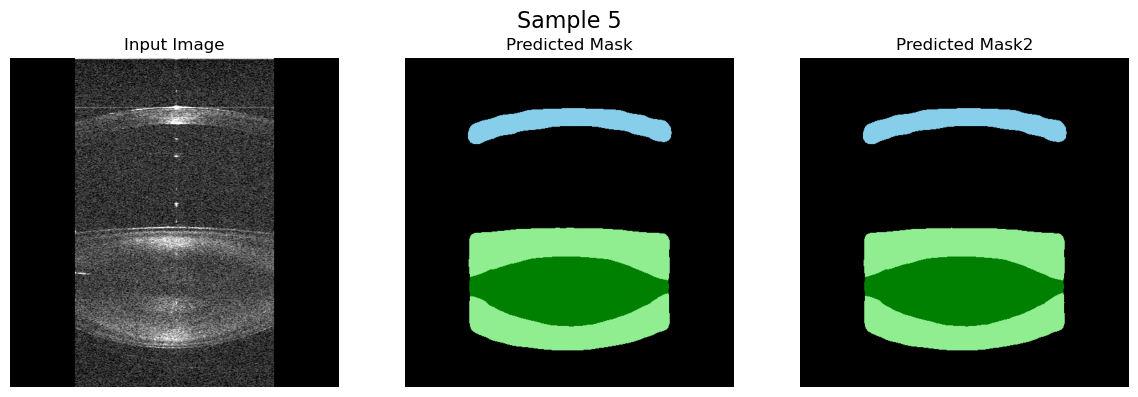

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.412383].


Sample 6: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


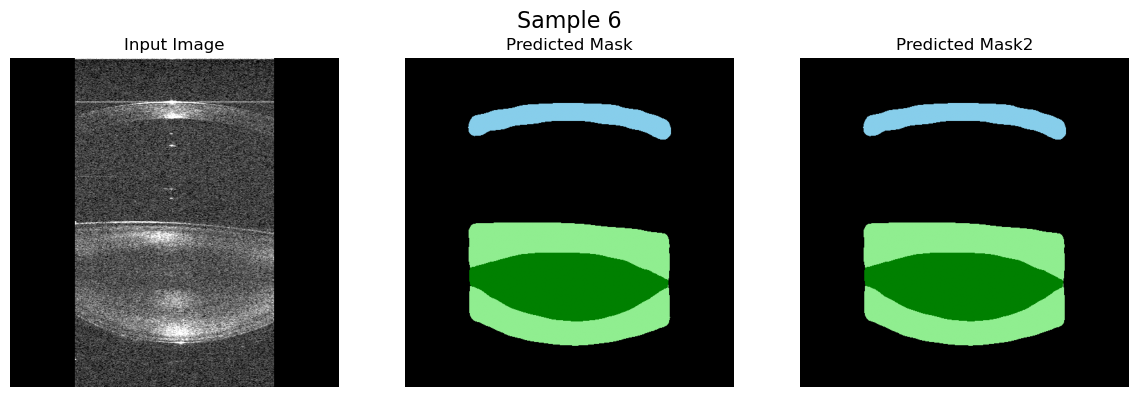

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.3505611].


Sample 7: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


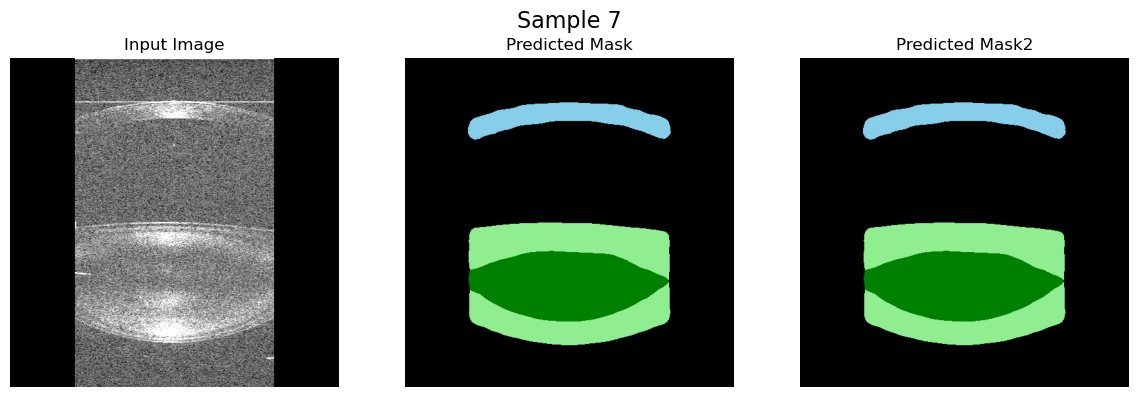

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.3711686].


Sample 8: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


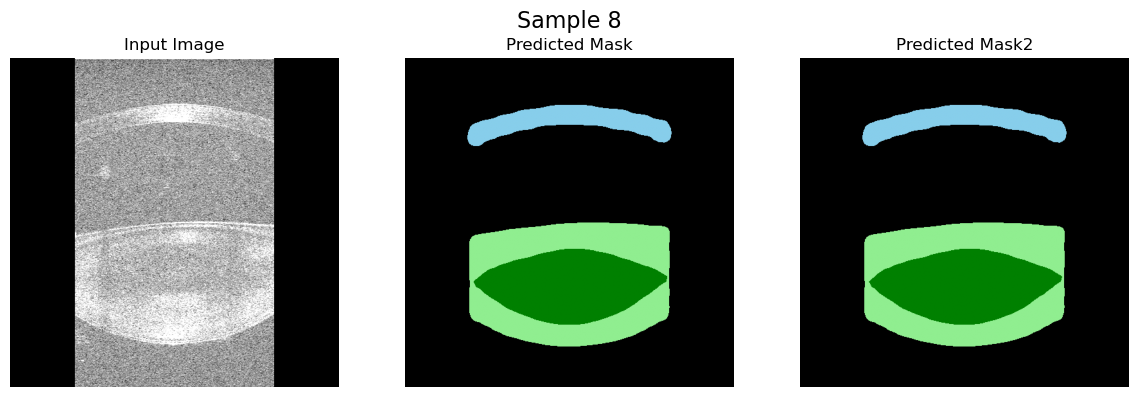

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.412383].


Sample 9: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


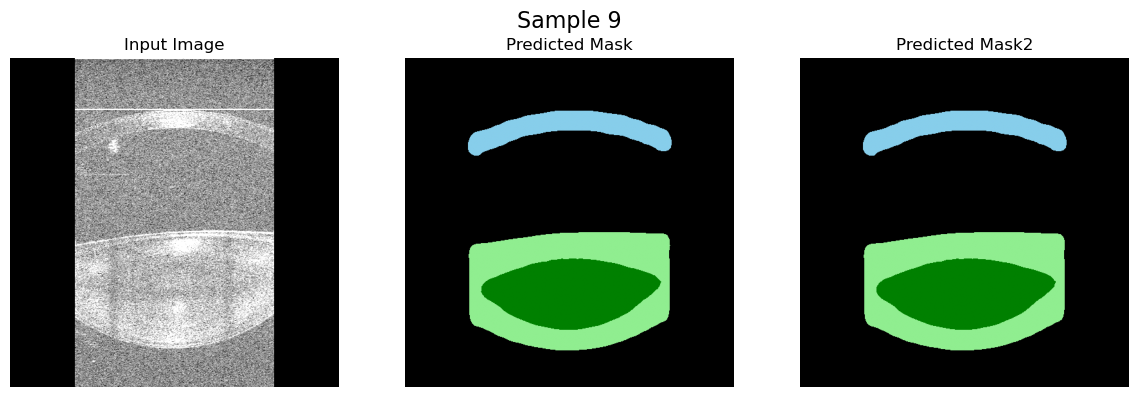

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.1857028].


Sample 10: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


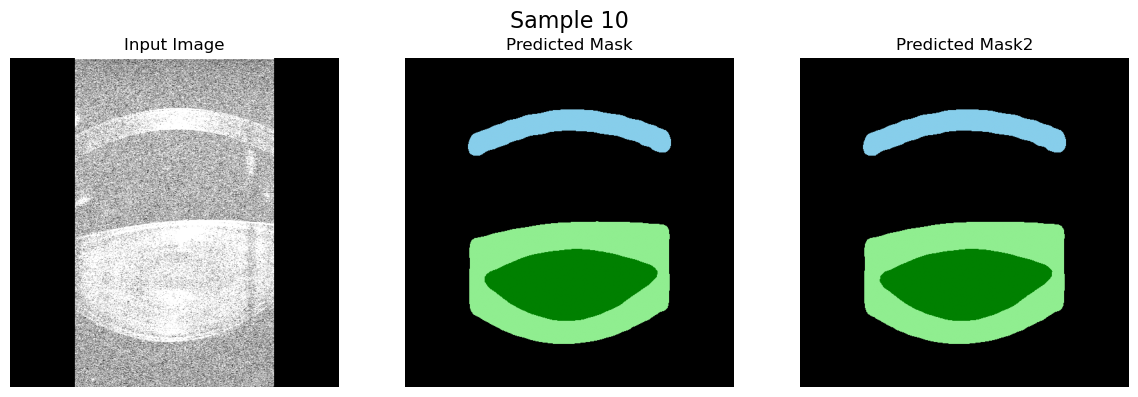

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..2.97963].


Sample 11: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


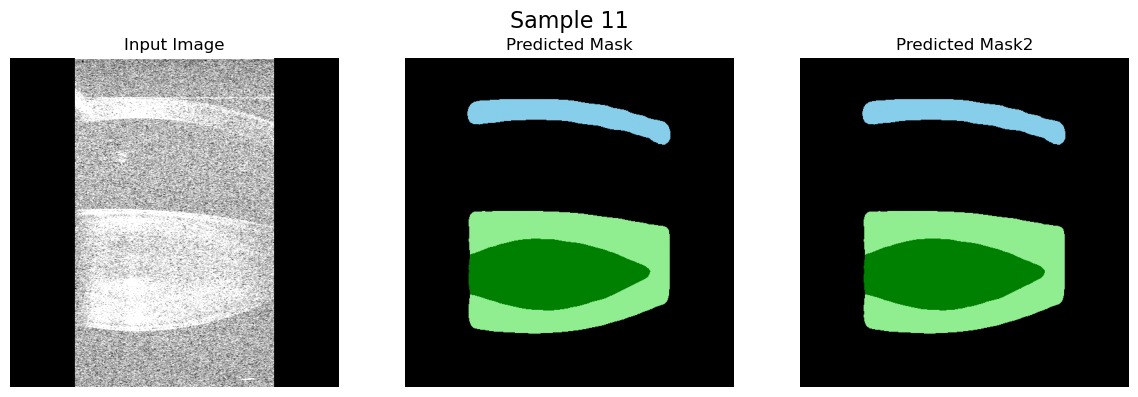

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.2475247].


Sample 12: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


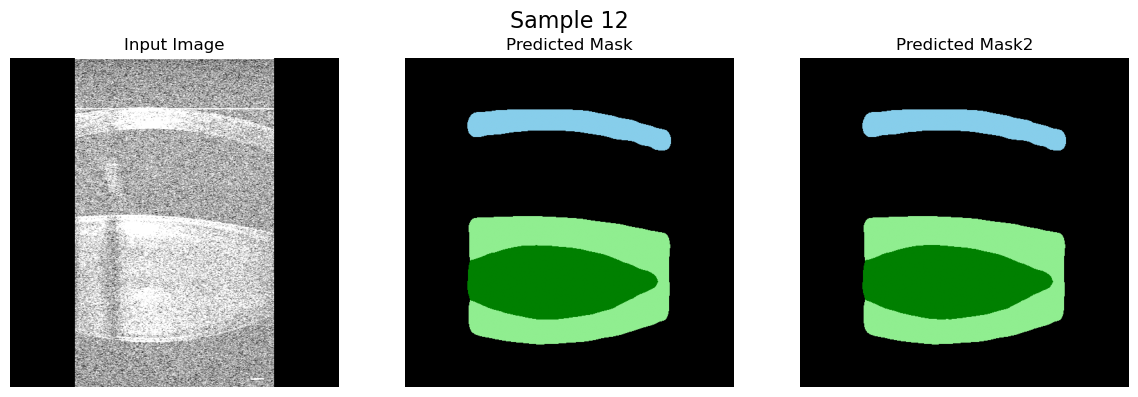

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.2887392].


Sample 13: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


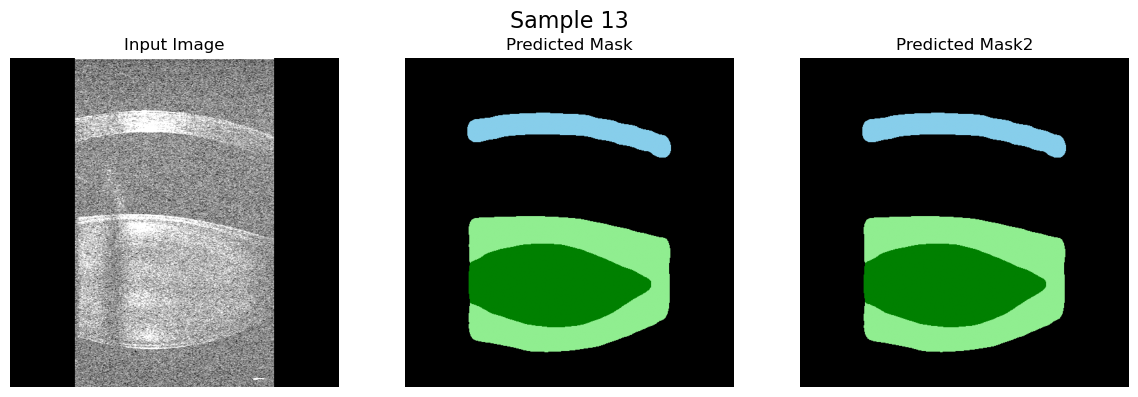

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..2.7941642].


Sample 14: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


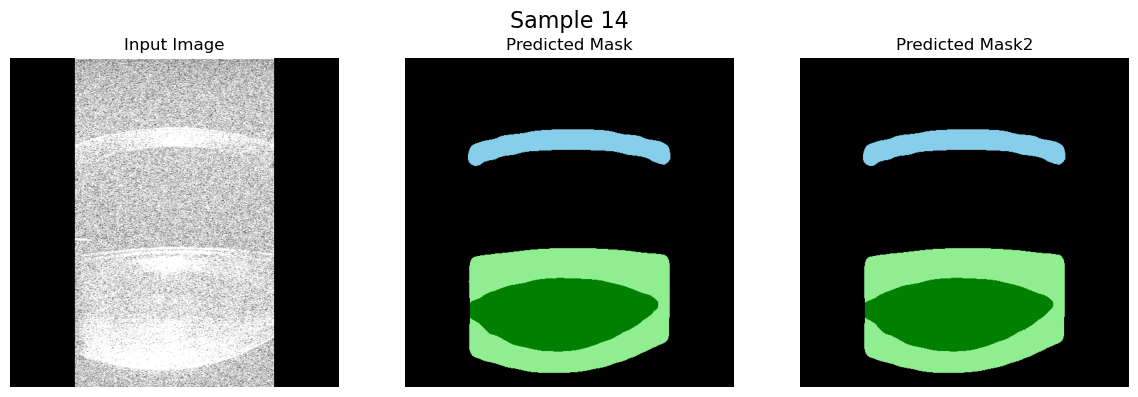

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.5154195].


Sample 15: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


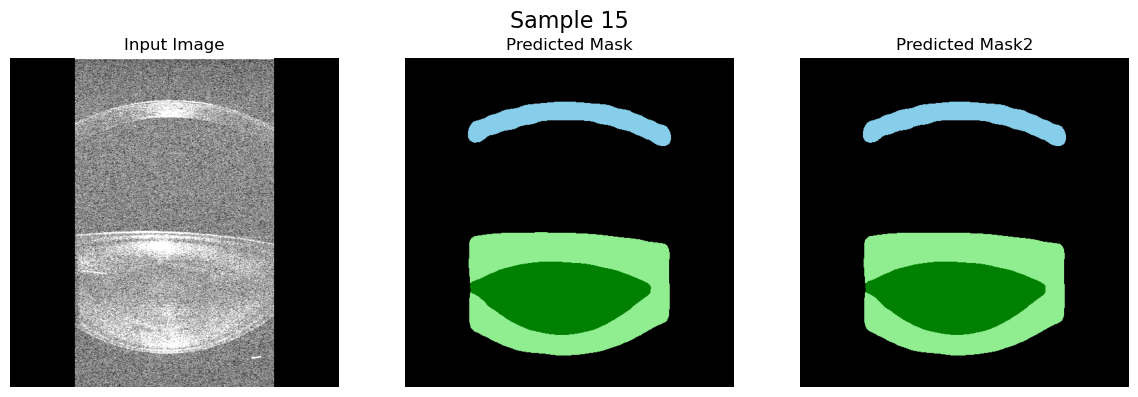

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.2887392].


Sample 16: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


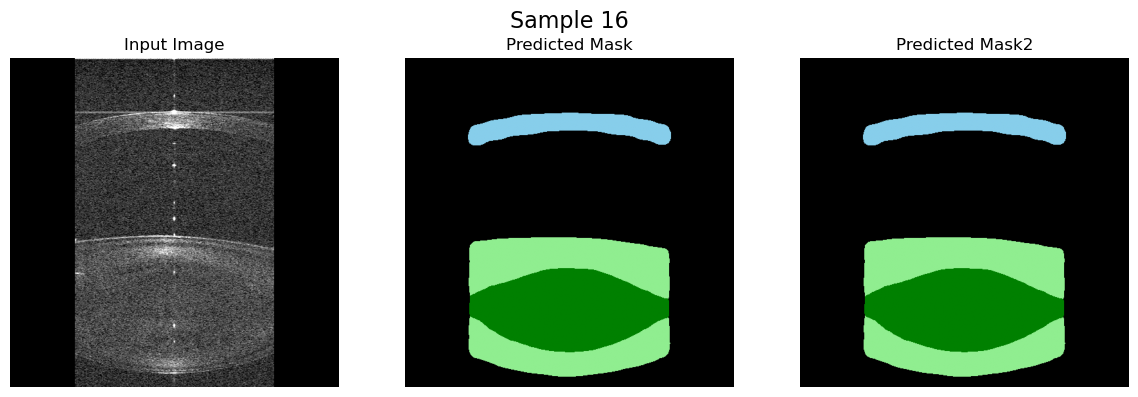

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.4535978].


Sample 17: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


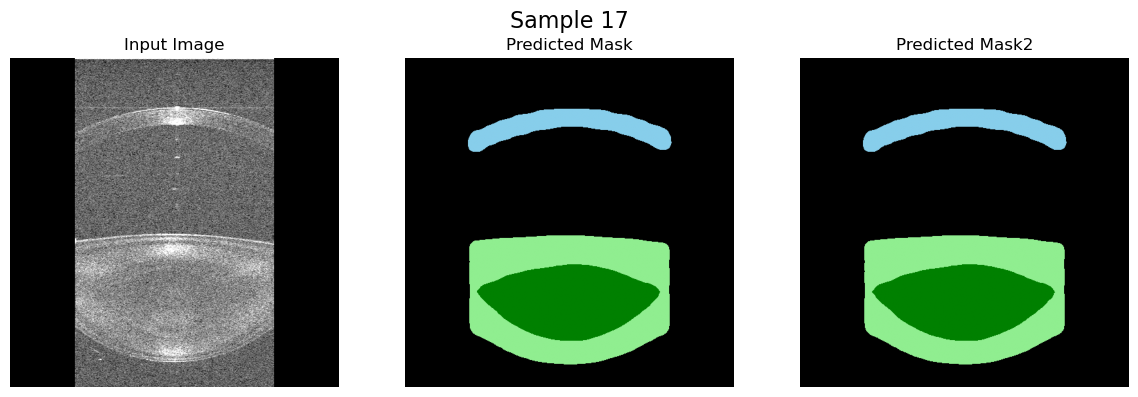

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.4948123].


Sample 18: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


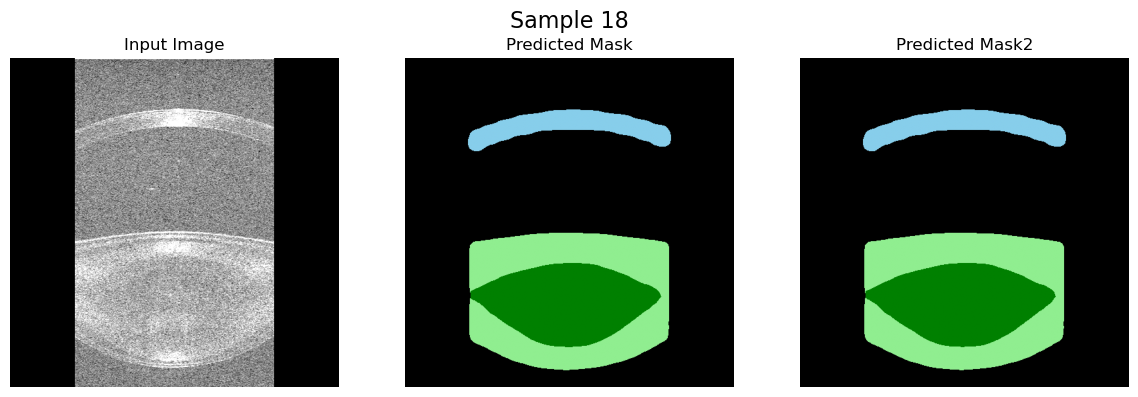

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.1238809].


Sample 19: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


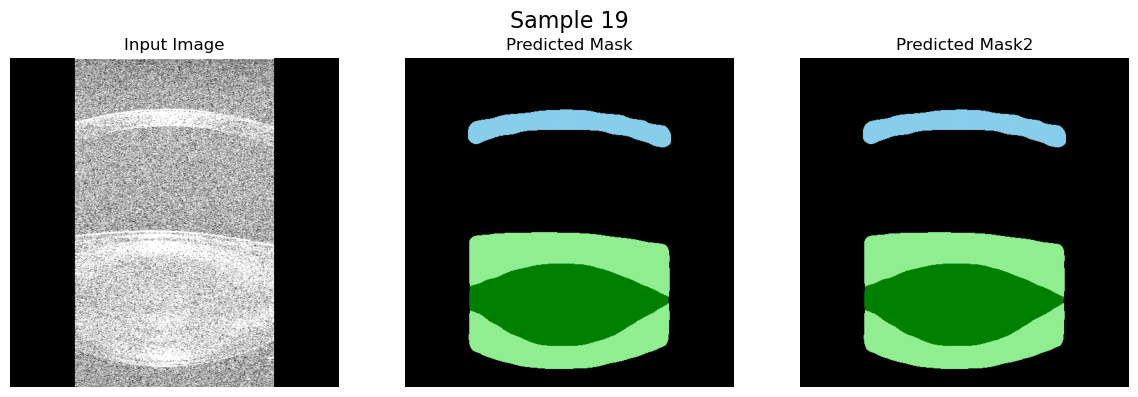

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823962..3.3711686].


Sample 20: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


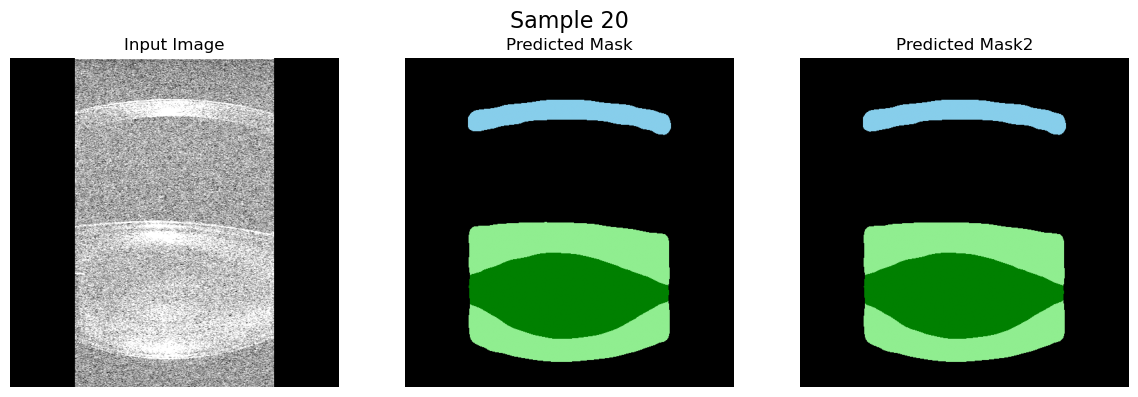

: 

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from lib.dataloader import OCTSegDataset
from torchvision import models, transforms
import torch.nn as nn
import numpy as np
from matplotlib.colors import ListedColormap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_root = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/eye_data"  # change to your dataset folder
mean = [0.0918, 0.0918, 0.0918]
std = [0.1903, 0.1903, 0.1903]


colors = ['black', 'skyblue', 'lightgreen', 'green']
cmap = ListedColormap(colors)
class_names = ['', 'Cornea', 'Lense', 'Nucleus']

# Validation dataset
val_dataset = OCTSegDataset(root_dir=data_root, split="val")
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

num_classes = 4
model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1))

model2 = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
model2.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1))

# Load checkpoint
checkpoint_path = "runs/DeepLabV3_ResNet50_20251006_140615/checkpoints/DeepLabV3_ResNet50_epoch_20.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

checkpoint_path2 = "runs/DeepLabV3_ResNet50_20251006_140615/checkpoints/DeepLabV3_ResNet50_best.pth"
checkpoint2 = torch.load(checkpoint_path2, map_location=device)

# Depending on how you saved the model:
if "state_dict" in checkpoint:
    model.load_state_dict(checkpoint["state_dict"])
    model2.load_state_dict(checkpoint2["state_dict"])
else:
    model.load_state_dict(checkpoint)
    model2.load_state_dict(checkpoint2)

# checkpoint = torch.load(checkpoint_path, map_location=device)
# model.load_state_dict(checkpoint["state_dict"])

model.to(device)
model2.to(device)

model.eval()
model2.eval()

with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # [B,H,W]

        # mean2 = torch.tensor([0.0918, 0.0918, 0.0918], device=images.device).view(1, 3, 1, 1)
        # std2 = torch.tensor([0.1903, 0.1903, 0.1903], device=images.device).view(1, 3, 1, 1)
        # images2 = (images - mean2) / std2
        outputs2 = model2(images)['out']
        preds2 = torch.argmax(outputs2, dim=1).cpu().numpy()  # [B,H,W]
        
        images = images.cpu()
        targets = targets.cpu().numpy()

        batch_size = images.shape[0]

        # Plotting all predictions in the batch
        for i in range(batch_size):
            img = images[i]
            label = targets[i]
            pred = preds[i]
            pred2 = preds2[i]
            print(f"Sample {i+1}: Unique classes in label: {np.unique(label)}, in pred: {np.unique(pred)}, in pred2: {np.unique(pred2)}")

            # Denormalize for visualization
            img = img.numpy().transpose(1, 2, 0)  # from [C,H,W] to [H,W,C]
            # img = img * std + mean  # undo normalization
            # img = np.clip(img, 0, 1)

            plt.figure(figsize=(12, 4))
            plt.suptitle(f"Sample {i+1}", fontsize=16)

            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            im = plt.imshow(pred2, cmap=cmap, vmin=0, vmax=3)
            # cbar = plt.colorbar(im, ticks=[0, 1, 2, 3])
            # cbar.ax.set_yticklabels(class_names)
            plt.title("Predicted Mask2")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
        
        # Just plot the first batch
        break